# MTH786P Project - Diabetes Prediction

#### Thanh Trung Vu - 230849442

## Import

In [1]:
import numpy as np
from numpy.testing import assert_array_almost_equal, assert_array_equal
from functools import cache
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from functools import cache
import sklearn
from sklearn import svm, linear_model
import time
import random


# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# dir(sklearn)

## Data Analysis

### Information about the Dataset


#### Context

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

All people represented in this dataset are females at least 21 years old of Pima Indian heritage.
    
- $\mathtt{Pregnancies}$ - number of times pregnant;
- $\mathtt{Glucose}$ - plasma glucose concentration a 2 hours in an oral glucose tolerance test;
- $\mathtt{BloodPressure}$ - diastolic blood pressure (mm Hg);
- $\mathtt{SkinThickness}$ - triceps skin fold thickness (mm);
- $\mathtt{Insulin}$ - 2-Hour serum insulin (mu U/ml);
- $\mathtt{BMI}$ - body mass index (weight in kg/(height in m)^2);
- $\mathtt{DiabetesPedigreeFunction} \quad \mathtt{(DPF)}$ - diabetes pedigree function;
- $\mathtt{Age}$ - age (years);
- $\mathtt{Outcome}$ - class variable (0 or 1).


#### Source

From https://www.kaggle.com/datasets/mathchi/diabetes-data-set.

##### (a) Original owners: National Institute of Diabetes and Digestive and Kidney Diseases



##### (b) Donor of database: Vincent Sigillito (vgs@aplcen.apl.jhu.edu)

Research Center, RMI Group Leader

Applied Physics Laboratory

The Johns Hopkins University

Johns Hopkins Road

Laurel, MD 20707

(301) 953-6231

##### (c) Date received: 9 May 1990

### Reading the data

We start by loading the data. For ease of analysis and processing, I will read the data into a pandas dataframe and later convert it into a numpy array for training. This is ok for a small dataset like this one, but for larger datasets, it may be better to read the data directly into a numpy array.

I also use a function to read the data and cache it in memory. When the function is called again, the data is already stored in memory so the file will not be read again. This will still produce a copy of the data when assigning it to a variable.

In [2]:
@cache
def get_diabetes_df_cached():
    diabetes_df = pd.read_csv('diabetes.csv')
    return diabetes_df

get_diabetes_df_cached().describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

### Analysis Functions

I will define some functions to help make the analysis a bit easier. I want to make some simple pair plots and correlation matrix to get a feel for the data and the relationship between the features and the target variable, as well as do some replacement of values to see what the data will look like after processing.

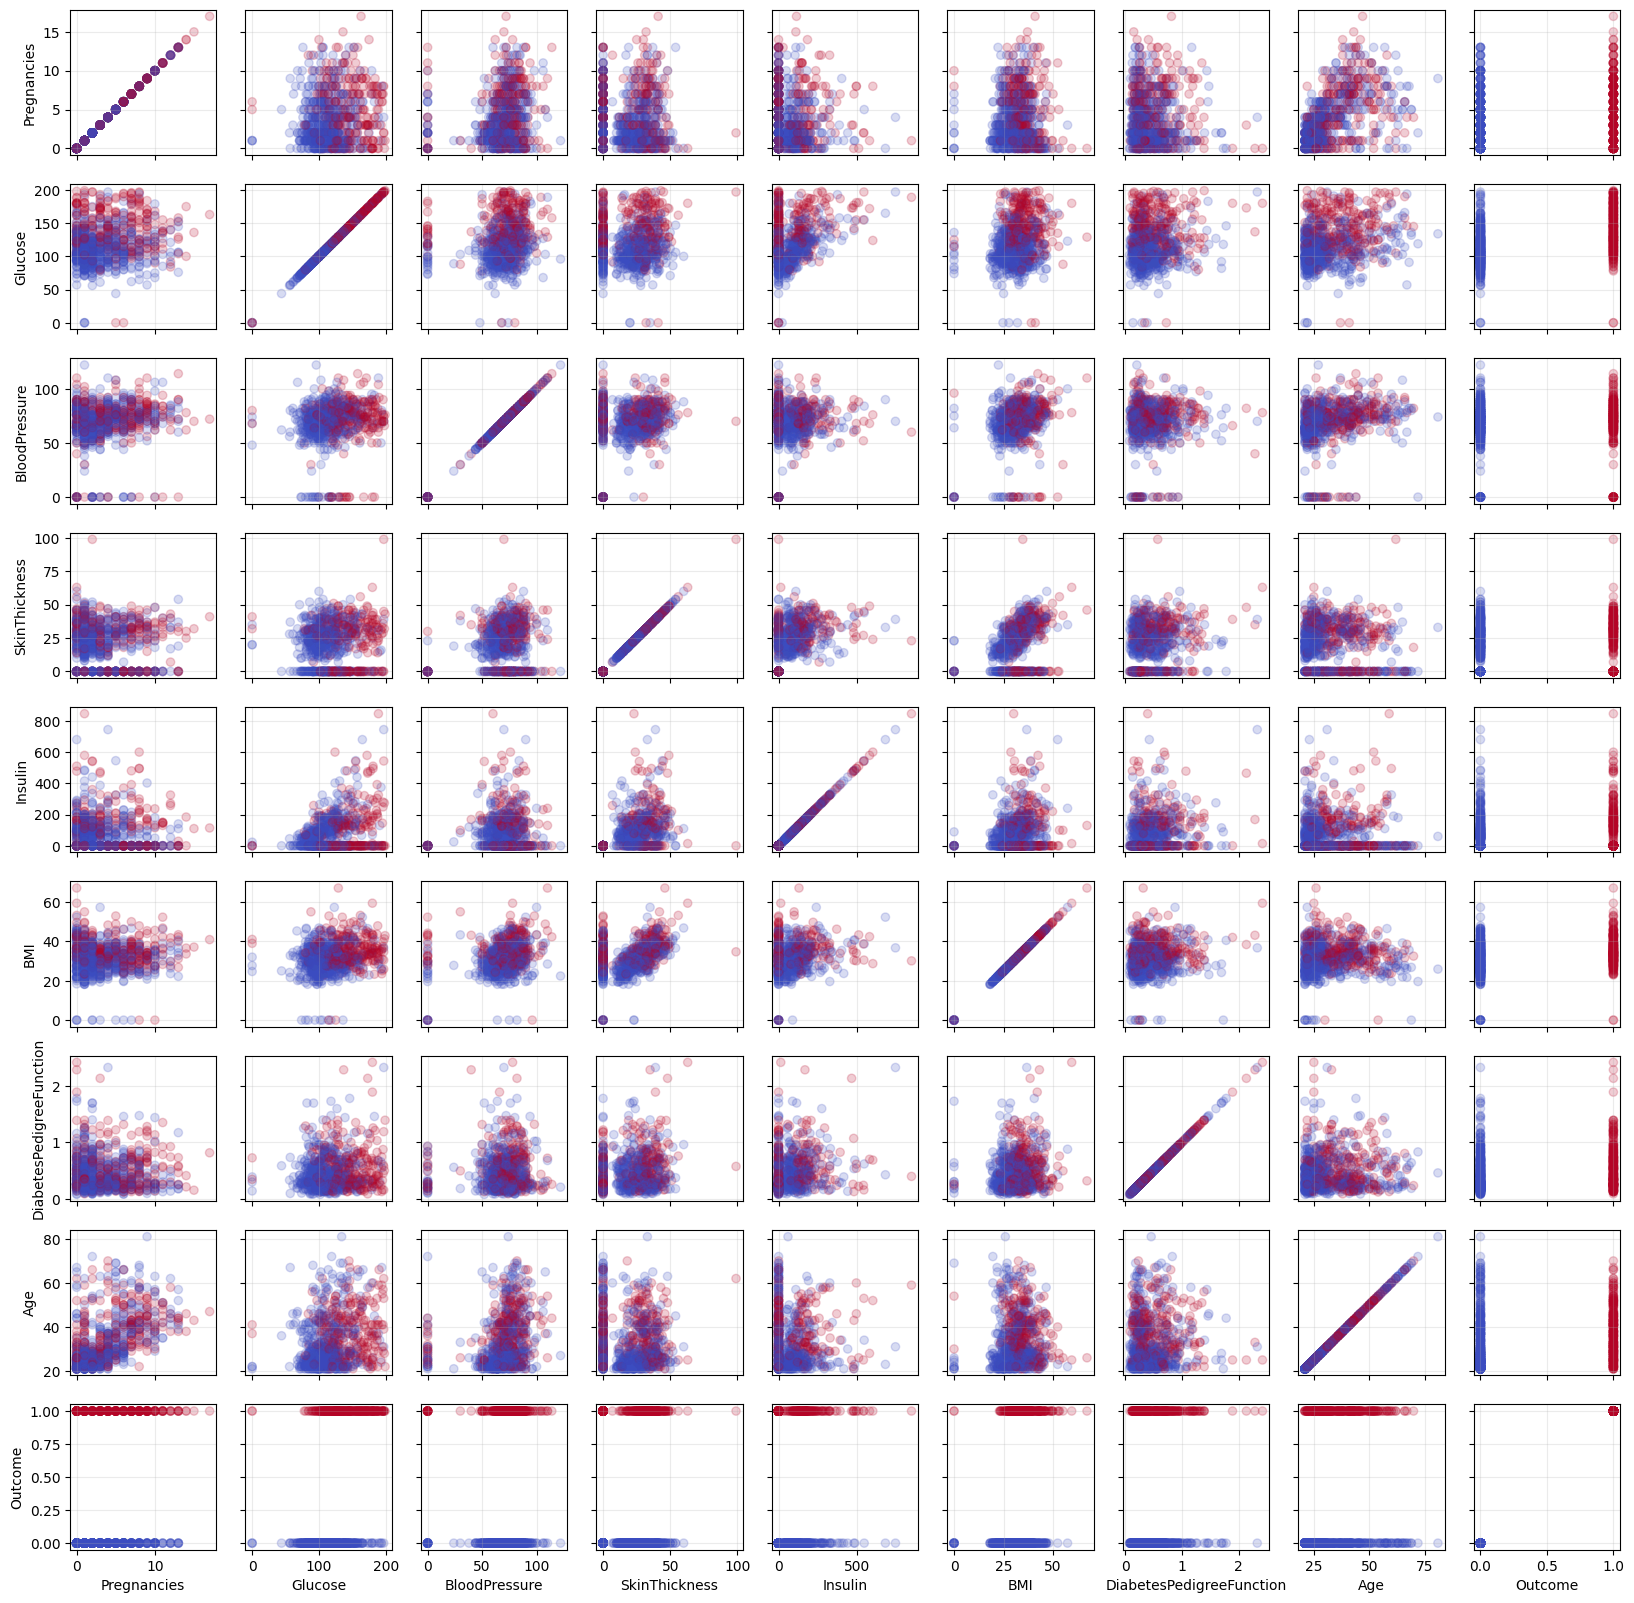

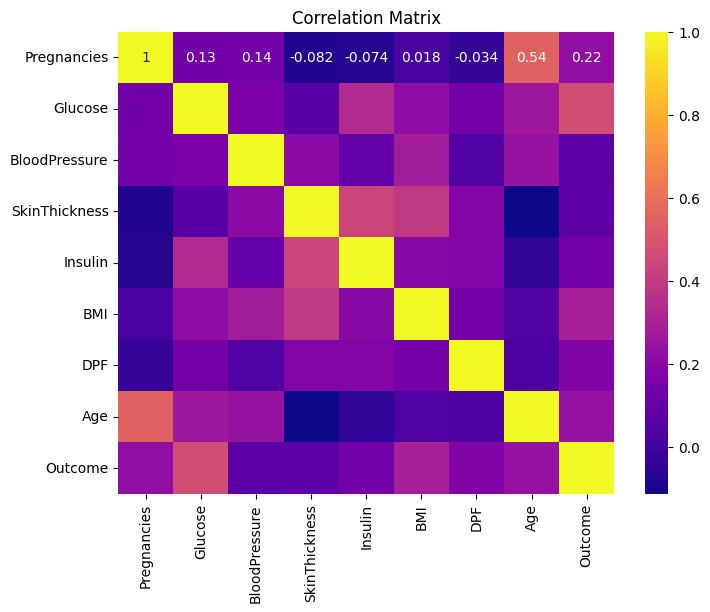

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [3]:
# Plot pair plot and correlation matrix, and print correlation values between features and target variable

def plot_pairplot(df):
    # sns.pairplot(df, hue='Outcome') # For some reason, sns.pairplot only plots 8 out of 9 columns, leaving out the Outcome column
    # Plot pairplots using plt
    no_of_columns = len(df.columns)
    fig, ax = plt.subplots(nrows=no_of_columns, ncols=no_of_columns)
    fig.set_size_inches(w=20,h=20)
    for i in range (no_of_columns):
        for j in range (no_of_columns):
            ax[i][j].scatter(
                df.iloc[:,j],
                df.iloc[:,i],
                c=df['Outcome'],
                alpha=0.2,
                cmap='coolwarm',
            )
            # Only show y-axis label and tick labels on the leftmost column
            if j == 0:
                ax[i][j].set_ylabel(df.columns[i])
            else:
                ax[i][j].set_yticklabels([])
            # Only show x-axis label and tick labels on the bottom row
            if i == no_of_columns - 1:
                ax[i][j].set_xlabel(df.columns[j])
            else:
                ax[i][j].set_xticklabels([])
            ax[i][j].grid(alpha=0.25)
    plt.show();


def plot_correlation_matrix(df):
    plt.figure(figsize=(8, 6))
    # Rename column DiabetesPedigreeFunction to DPF
    df = df.copy()   # This is bad for performance.
    df.rename(columns={'DiabetesPedigreeFunction': 'DPF'}, inplace=True) # Change the name of the column to make the plot smaller
    sns.heatmap(df.corr(), annot=True, cmap='plasma')  # other values for cmap include 'coolwarm', 'viridis'
    # see https://matplotlib.org/stable/tutorials/colors/colormaps.html for more options color map options
    plt.title('Correlation Matrix')
    plt.show();


def print_correlation_between_outcome_and_features(df):
    # Print correlation values between features and target variable
    print(df.corr()['Outcome'].sort_values(ascending=False))


def analyse_correlation(df):
    plot_pairplot(df)  # Note that the pair plot might take a few seconds to appear
    plot_correlation_matrix(df)
    print_correlation_between_outcome_and_features(df)


analyse_correlation(df=get_diabetes_df_cached())

Looking at these graphs, we can see that some features contain strange values, in particular there seem some zeros in features such as $\mathtt{Glucose}$, $\mathtt{BloodPressure}$, $\mathtt{SkinThickness}$, $\mathtt{Insulin}$ and $\mathtt{BMI}$. Considering the meaning of these features, it does not make sense to find zeros and can only be explained lack of data. There might also be values that are too large which suggest measurement errors. We will take a closer look at all the features.

Regarding the correlation, we can see that there is a strong correlation between $\mathtt{Age}$ and $\mathtt{Pregnancies}$, which makes sense. There is also a strong correlation between $\mathtt{Glucose}$ and $\mathtt{Outcome}$, which is also makes sense for the diabetes disease. On the other hand, $\mathtt{BloodPressure}$ and $\mathtt{SkinThickness}$ do not seem to have a strong correlation with the outcome. They can be considered as weak predictors and may be removed.

I will also make a function to replace the values. I will describe its usage in more details during the feature analysis.

In [4]:
def replace_value(df, feature_name, values_to_replace=[0], max_include=None, replacement="Mean"):
    df = df.copy()

    for value_to_replace in values_to_replace:
        df[feature_name] = df[feature_name].replace(value_to_replace, np.NaN)
    if max_include is not None:
        mask = df[feature_name] > max_include
        df.loc[mask, feature_name] = np.NaN

    value_to_replace_with = df[feature_name].mean() if replacement == "Mean" else df[feature_name].median()

    string = str(values_to_replace[0])
    for i in range(1, len(values_to_replace) - 1):
        string += f", {values_to_replace[i]}"
    if len(values_to_replace) > 1: string += f" and {values_to_replace[-1]}"
    if max_include is not None: string += f" and values > {max_include}"
    values_to_replace = string

    print(f"Replacing {values_to_replace} with {replacement} {value_to_replace_with} ({replacement} value calculated excluding {values_to_replace})")
    df[feature_name] = df[feature_name].fillna(value_to_replace_with)
    return df

### Individually Analyse the Features

Let's define a function to help analyse a feature by plotting a histogram and a boxplot as well as printing some key statistics.

In [5]:
def analyse_feature(feature_name, df=get_diabetes_df_cached(), after_processing=False):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(w=8,h=3)

    def add_lines_mean_and_median(axis):
        axis.axvline(
            df[feature_name].mean(),
            # color='red',
            color='green',
            linestyle='dashed',
            linewidth=0.8
        )
        axis.axvline(
            df[feature_name].median(),
            color='green',
            # linestyle='dashed',
            linewidth=0.8
        )

    ax_left = ax[0]
    sns.histplot(df[feature_name], bins=40, ax=ax_left)
    add_lines_mean_and_median(ax_left)
    ax_left.grid(alpha=0.25)

    ax_right = ax[1]
    sns.boxplot(x=df[feature_name], ax=ax_right)
    add_lines_mean_and_median(ax_right)
    ax_right.grid(alpha=0.25)

    fig.suptitle(f"Distribution of feature {feature_name}" + (" (after processing)" if after_processing else ""))
    plt.show()

    print(f"Feature name is {feature_name}")
    print(f"Data Type: {df[feature_name].dtype}")
    print(f"Number of unique values: {df[feature_name].nunique()}")
    print(f"Count of NaN: {df[df[feature_name].isna()].shape[0]}")
    print(f"Count of 0: {df[df[feature_name] == 0].shape[0]}")

    print(f"\nStatistics of {feature_name}: \n{df[feature_name].describe()}")
    print(f"Count of min value: {df[df[feature_name] == df[feature_name].min()].shape[0]}")
    print(f"Count of max value: {df[df[feature_name] == df[feature_name].max()].shape[0]}")

    def print_outliers_and_normal_values():
        # Get the outliers using the same method as in the boxplot
        lower_quantile = 0.25
        upper_quantile = 0.75
        q1 = df[feature_name].quantile(lower_quantile)
        q3 = df[feature_name].quantile(upper_quantile)
        iqr = q3 - q1
        print(f"Using lower quantile of {lower_quantile} to calculate normal values and outliers")
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = df[(df[feature_name] < lower_bound) | (df[feature_name] > upper_bound)][feature_name].value_counts()
        outliers.sort_index(inplace=True)
        print(f"\nNumber of outliers: {outliers.sum()}")
        # print(outliers)
        # If more than 4 outliers, print the first 2, then some ..., then the last 2
        if outliers.shape[0] > 0:
            print(f"Outlier counts:")
            print(f"Val  Count")
            if outliers.shape[0] > 4:
                print(f"Outlier counts:")
                print(f"Val  Count")
                print(f"{outliers.index[0]}  {outliers.iloc[0]}")
                print(f"{outliers.index[1]}  {outliers.iloc[1]}")
                print(f" ...")
                print(f"{outliers.index[-2]}  {outliers.iloc[-2]}")
                print(f"{outliers.index[-1]}  {outliers.iloc[-1]}")
            else:
                print(outliers)

        # Get the range of normal values
        normal_values = df[(df[feature_name] >= lower_bound) & (df[feature_name] <= upper_bound)][feature_name]
        print(f"\nNormal values of {feature_name} are between {normal_values.min()} and {normal_values.max()}")
        print(f"Mean of normal values: {normal_values.mean()}")
        print(f"Median of normal values: {normal_values.median()}")

    print_outliers_and_normal_values()

#### Pregnancies

Pregnancies: Number of times pregnant

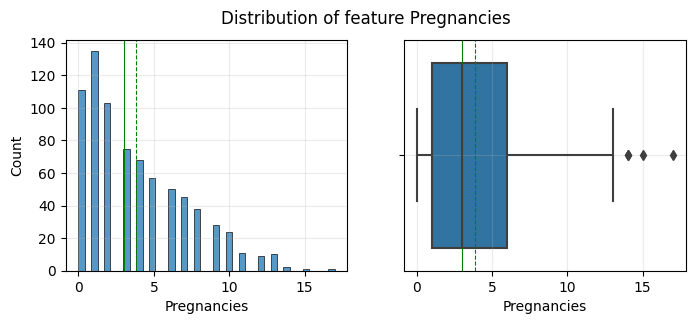

Feature name is Pregnancies
Data Type: int64
Number of unique values: 17
Count of NaN: 0
Count of 0: 111

Statistics of Pregnancies: 
count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64
Count of min value: 111
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 4
Outlier counts:
Val  Count
14    2
15    1
17    1
Name: Pregnancies, dtype: int64

Normal values of Pregnancies are between 0 and 13
Mean of normal values: 3.7866492146596857
Median of normal values: 3.0


In [6]:
analyse_feature('Pregnancies')

There are 111 out of 768 women who were never pregnant. 

Remember: Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Perhaps many were young and did not have children at the time of the study.

There are some people with very high count of pregnancies. The maximum is 17. This is possible, but rare.

There are no missing (NaN) values.

Overall, the numbers look reasonable. No processing is needed for this feature.

#### Glucose

Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

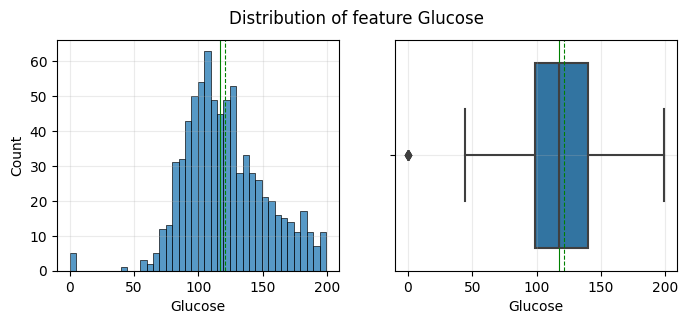

Feature name is Glucose
Data Type: int64
Number of unique values: 136
Count of NaN: 0
Count of 0: 5

Statistics of Glucose: 
count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64
Count of min value: 5
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 5
Outlier counts:
Val  Count
0    5
Name: Glucose, dtype: int64

Normal values of Glucose are between 44 and 199
Mean of normal values: 121.6867627785059
Median of normal values: 117.0


In [7]:
analyse_feature('Glucose')

There are a lot of 0s in the glucose column. This is probably because for many people in the dataset, their glucose level was not measured. I will replace these values with the mean of the non-zero values which is around 121.7.

Replacing 0 with Mean 121.6867627785059 (Mean value calculated excluding 0)


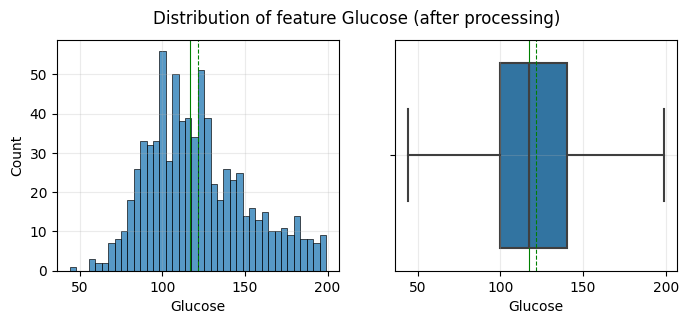

Feature name is Glucose
Data Type: float64
Number of unique values: 136
Count of NaN: 0
Count of 0: 0

Statistics of Glucose: 
count    768.000000
mean     121.686763
std       30.435949
min       44.000000
25%       99.750000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64
Count of min value: 1
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 0

Normal values of Glucose are between 44.0 and 199.0
Mean of normal values: 121.68676277850587
Median of normal values: 117.0


In [8]:
analyse_feature('Glucose', replace_value(get_diabetes_df_cached(), 'Glucose', replacement='Mean'), after_processing=True)

The values now look more reasonable.

Let's move on to Blood Pressure.

#### Blood Pressure

BloodPressure: Diastolic blood pressure (mm Hg)

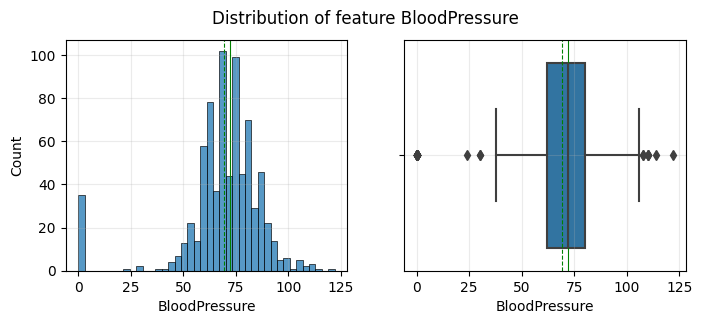

Feature name is BloodPressure
Data Type: int64
Number of unique values: 47
Count of NaN: 0
Count of 0: 35

Statistics of BloodPressure: 
count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64
Count of min value: 35
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 45
Outlier counts:
Val  Count
Outlier counts:
Val  Count
0  35
24  1
 ...
114  1
122  1

Normal values of BloodPressure are between 38 and 106
Mean of normal values: 72.2088520055325
Median of normal values: 72.0


In [9]:
analyse_feature('BloodPressure')

There are also a lot of zeros in the blood pressure column. This is again likely due to missing data. Again, I will replace these values with the mean of the non-zero values. Note that this is a bit different from the mean of the non-outliers.

Replacing 0 with Mean 72.40518417462484 (Mean value calculated excluding 0)


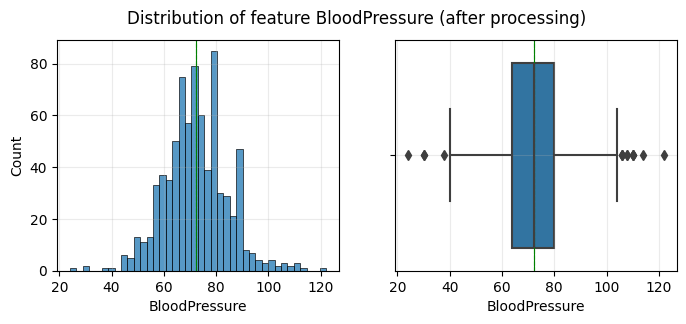

Feature name is BloodPressure
Data Type: float64
Number of unique values: 47
Count of NaN: 0
Count of 0: 0

Statistics of BloodPressure: 
count    768.000000
mean      72.405184
std       12.096346
min       24.000000
25%       64.000000
50%       72.202592
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64
Count of min value: 1
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 14
Outlier counts:
Val  Count
Outlier counts:
Val  Count
24.0  1
30.0  2
 ...
114.0  1
122.0  1

Normal values of BloodPressure are between 40.0 and 104.0
Mean of normal values: 72.12888785956484
Median of normal values: 72.0


In [10]:
analyse_feature('BloodPressure', replace_value(get_diabetes_df_cached(), 'BloodPressure', replacement='Mean'), after_processing=True)

The numbers now look more reasonable. Let's move on to Skin Thickness.

#### Skin Thickness

SkinThickness: Triceps skin fold thickness (mm)

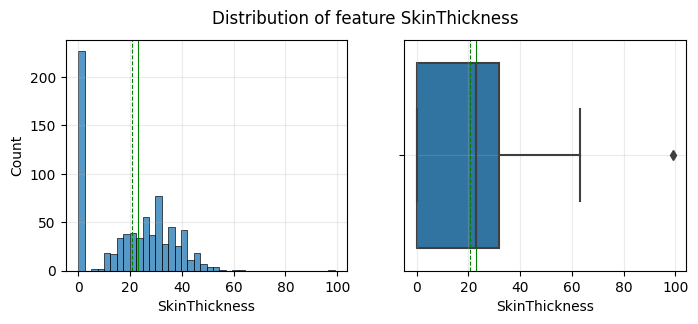

Feature name is SkinThickness
Data Type: int64
Number of unique values: 51
Count of NaN: 0
Count of 0: 227

Statistics of SkinThickness: 
count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64
Count of min value: 227
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 1
Outlier counts:
Val  Count
99    1
Name: SkinThickness, dtype: int64

Normal values of SkinThickness are between 0 and 63
Mean of normal values: 20.434159061277704
Median of normal values: 23.0


In [11]:
analyse_feature('SkinThickness')

There are a lot of zeros in the skin thickness column. This is again likely due to missing data. There is also a large value of 99 which is likely an outlier. I will again replace these with the mean of the non-zero values as calculated below. 

Replacing 0 and 99 with Mean 29.024074074074075 (Mean value calculated excluding 0 and 99)


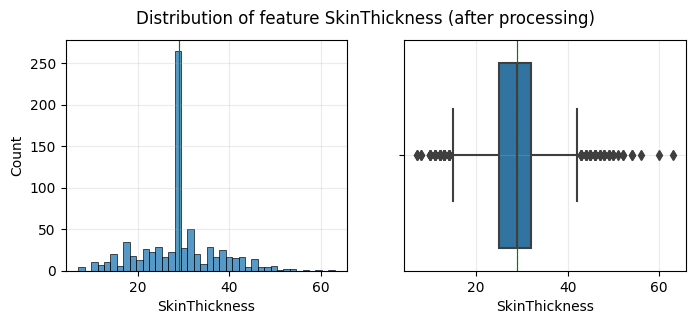

Feature name is SkinThickness
Data Type: float64
Number of unique values: 50
Count of NaN: 0
Count of 0: 0

Statistics of SkinThickness: 
count    768.000000
mean      29.024074
std        8.420708
min        7.000000
25%       25.000000
50%       29.024074
75%       32.000000
max       63.000000
Name: SkinThickness, dtype: float64
Count of min value: 2
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 86
Outlier counts:
Val  Count
Outlier counts:
Val  Count
7.0  2
8.0  2
 ...
60.0  1
63.0  1

Normal values of SkinThickness are between 15.0 and 42.0
Mean of normal values: 28.736787227109723
Median of normal values: 29.024074074074075


In [12]:
analyse_feature('SkinThickness', replace_value(get_diabetes_df_cached(), 'SkinThickness', [0, 99], replacement='Mean'), after_processing=True)

Although there are still some values that seem much smaller or larger than the normal values, I will leave them as they are for now.

#### Insulin

Insulin: 2-Hour serum insulin (mu U/ml)

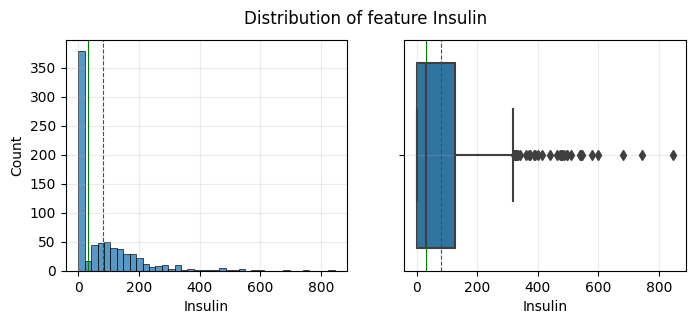

Feature name is Insulin
Data Type: int64
Number of unique values: 186
Count of NaN: 0
Count of 0: 374

Statistics of Insulin: 
count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64
Count of min value: 374
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 34
Outlier counts:
Val  Count
Outlier counts:
Val  Count
321  1
325  3
 ...
744  1
846  1

Normal values of Insulin are between 0 and 318
Mean of normal values: 62.328337874659404
Median of normal values: 0.0


In [13]:
analyse_feature('Insulin')

There are also a lot of zeros in the insulin column which once again suggests missing data, probably because of the lack of capacity to carry out measurements. 

According to https://emedicine.medscape.com/article/2089224-overview?form=fpf, an insulin level is mostly between 16-166 mIU/L.

There are some very large values which are likely due to a measurement or data entry error. I will replace both zeros and values greater than 200.

Replacing 0 and values > 200 with Mean 107.07766990291262 (Mean value calculated excluding 0 and values > 200)


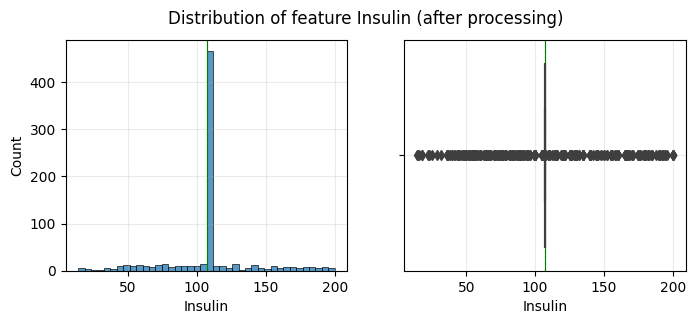

Feature name is Insulin
Data Type: float64
Number of unique values: 121
Count of NaN: 0
Count of 0: 0

Statistics of Insulin: 
count    768.000000
mean     107.077670
std       30.205298
min       14.000000
25%      107.077670
50%      107.077670
75%      107.077670
max      200.000000
Name: Insulin, dtype: float64
Count of min value: 1
Count of max value: 4
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 309
Outlier counts:
Val  Count
Outlier counts:
Val  Count
14.0  1
15.0  1
 ...
196.0  1
200.0  4

Normal values of Insulin are between 107.07766990291262 and 107.07766990291262
Mean of normal values: 107.07766990291336
Median of normal values: 107.07766990291262


In [14]:
analyse_feature('Insulin', replace_value(get_diabetes_df_cached(), 'Insulin', [0], 200, replacement='Mean'), after_processing=True)

Note that many Insulin values are now identical. This might affect the performance of the model. I will leave it as it is for now.

#### BMI

BMI: Body mass index (weight in kg/(height in m)^2)

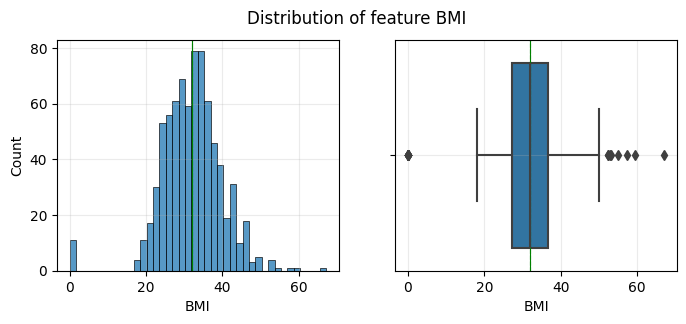

Feature name is BMI
Data Type: float64
Number of unique values: 248
Count of NaN: 0
Count of 0: 11

Statistics of BMI: 
count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64
Count of min value: 11
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 19
Outlier counts:
Val  Count
Outlier counts:
Val  Count
0.0  11
52.3  2
 ...
59.4  1
67.1  1

Normal values of BMI are between 18.2 and 50.0
Mean of normal values: 32.204005340453925
Median of normal values: 32.0


In [15]:
analyse_feature('BMI')

There are 11 zeros in the BMI column which are not valid BMI values and again suggests missing values. I will replace them with the mean.

Replacing 0 with Mean 32.45746367239099 (Mean value calculated excluding 0)


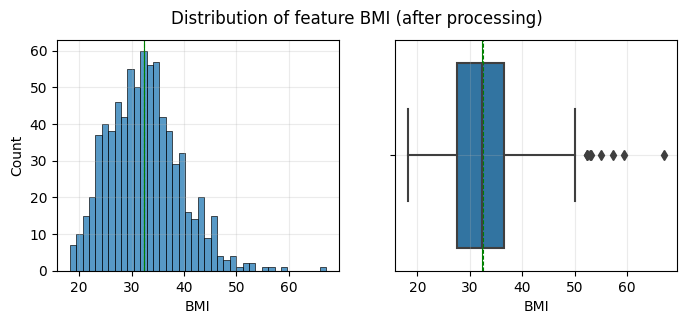

Feature name is BMI
Data Type: float64
Number of unique values: 248
Count of NaN: 0
Count of 0: 0

Statistics of BMI: 
count    768.000000
mean      32.457464
std        6.875151
min       18.200000
25%       27.500000
50%       32.400000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64
Count of min value: 3
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 8
Outlier counts:
Val  Count
Outlier counts:
Val  Count
52.3  2
52.9  1
 ...
59.4  1
67.1  1

Normal values of BMI are between 18.2 and 50.0
Mean of normal values: 32.20767381631091
Median of normal values: 32.349999999999994


In [16]:
analyse_feature('BMI', replace_value(get_diabetes_df_cached(), 'BMI', [0], replacement='Mean'), after_processing=True)

The values now look more reasonable.

#### Diabetes Pedigree Function

DiabetesPedigreeFunction: Diabetes pedigree function

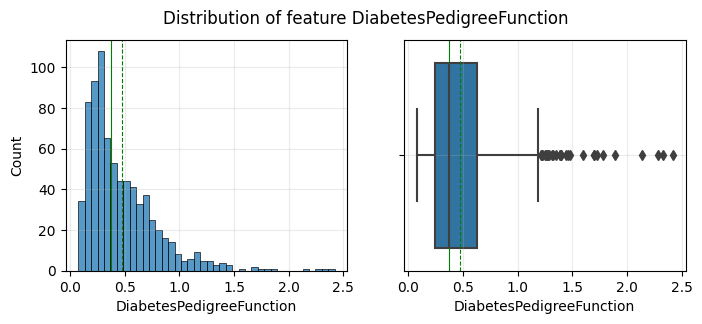

Feature name is DiabetesPedigreeFunction
Data Type: float64
Number of unique values: 517
Count of NaN: 0
Count of 0: 0

Statistics of DiabetesPedigreeFunction: 
count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64
Count of min value: 1
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 29
Outlier counts:
Val  Count
Outlier counts:
Val  Count
1.213  1
1.222  1
 ...
2.329  1
2.42  1

Normal values of DiabetesPedigreeFunction are between 0.078 and 1.191
Mean of normal values: 0.42983220568335573
Median of normal values: 0.356


In [17]:
analyse_feature('DiabetesPedigreeFunction')

The values of Pedigree Function seem ok. No processing is needed for this feature for now.

#### Age

Age: Age (years)

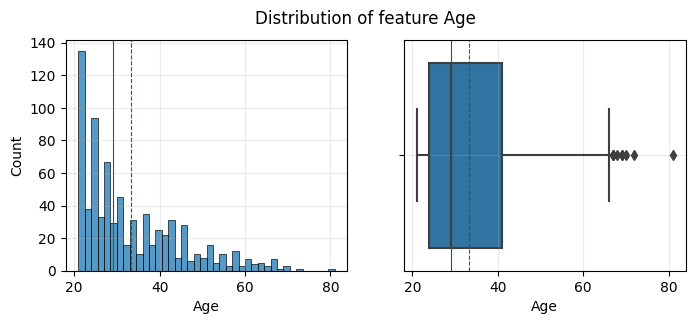

Feature name is Age
Data Type: int64
Number of unique values: 52
Count of NaN: 0
Count of 0: 0

Statistics of Age: 
count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64
Count of min value: 63
Count of max value: 1
Using lower quantile of 0.25 to calculate normal values and outliers

Number of outliers: 9
Outlier counts:
Val  Count
Outlier counts:
Val  Count
67  3
68  1
 ...
72  1
81  1

Normal values of Age are between 21 and 66
Mean of normal values: 32.80500658761528
Median of normal values: 29.0


In [18]:
analyse_feature('Age')

The values for age look ok. No processing is needed for this feature for now.

#### Outcome

Outcome: Class variable (0 or 1)

Number of people: 768
People with diabetes: 268
Percentage of people with diabetes: 34.90%


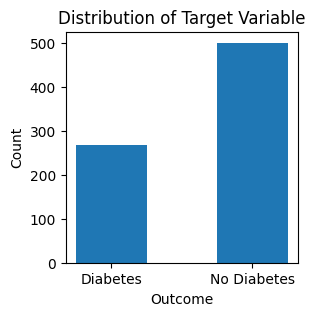

In [19]:
def plot_target():
    no_of_people = get_diabetes_df_cached()['Outcome'].shape[0]
    no_of_patients = get_diabetes_df_cached()['Outcome'].sum()
    print(f"Number of people: {no_of_people}")
    print(f"People with diabetes: {no_of_patients}")
    print(f"Percentage of people with diabetes: {no_of_patients / no_of_people * 100:.2f}%")
    plt.figure().set_size_inches(w=3,h=3)
    plt.bar(get_diabetes_df_cached()['Outcome'].unique(), get_diabetes_df_cached()['Outcome'].value_counts(), width=0.5, align='center', tick_label=['No Diabetes', 'Diabetes'])
    plt.xlabel('Outcome')
    plt.ylabel('Count')
    plt.title('Distribution of Target Variable')
    plt.show();

plot_target()

The proportion of people with diabetes is 34.9% so the data is not balanced. It is not too imbalanced, so I will not do anything about it for now.

## Data Processing

Now that we have a better understanding of the features, I will try to replace the missing values and outliers as discussed during the analysis.

During my experiments, I also tried removing missing values and outliers. However, in the end I decided to keep as much data as possible since the dataset is already small to begin with.

In [20]:
def get_and_process_diabetes_df(features_to_drop=[], drop_outliers=False, processed=False):
    df = get_diabetes_df_cached()
    for feature in features_to_drop:
        df = df.drop(feature, axis=1)
    if drop_outliers:
        if 'Pregnancies' not in features_to_drop:
            df = df[df['Pregnancies'] > 0]
        if 'Glucose' not in features_to_drop:
            df = df[df['Glucose'] > 0]
        if 'SkinThickness' not in features_to_drop:
            df = df[df['SkinThickness'] > 0]
            df = df[df['SkinThickness'] < 99]
        if 'Insulin' not in features_to_drop:
            df = df[df['Insulin'] > 0]
            df = df[df['Insulin'] <= 200]
        if 'BMI' not in features_to_drop:
            df = df[df['BMI'] > 0]
    elif processed:
        if 'Glucose' not in features_to_drop:
            df = replace_value(df, 'Glucose', [0], replacement='Mean')
        if 'BloodPressure' not in features_to_drop:
            df = replace_value(df, 'BloodPressure', [0], replacement='Mean')
        if 'SkinThickness' not in features_to_drop:
            df = replace_value(df, 'SkinThickness', [0, 99], replacement='Mean')
        if 'Insulin' not in features_to_drop:
            df = replace_value(df, 'Insulin', [0], 200, replacement='Mean')
        if 'BMI' not in features_to_drop:
            df = replace_value(df, 'BMI', [0], replacement='Mean')
    return df

get_and_process_diabetes_df().describe()
get_and_process_diabetes_df(processed=True).describe()

Replacing 0 with Mean 121.6867627785059 (Mean value calculated excluding 0)
Replacing 0 with Mean 72.40518417462484 (Mean value calculated excluding 0)
Replacing 0 and 99 with Mean 29.024074074074075 (Mean value calculated excluding 0 and 99)
Replacing 0 and values > 200 with Mean 107.07766990291262 (Mean value calculated excluding 0 and values > 200)
Replacing 0 with Mean 32.45746367239099 (Mean value calculated excluding 0)


Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.686763      72.405184      29.024074  107.077670   
std       3.369578   30.435949      12.096346       8.420708   30.205298   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  107.077670   
50%       3.000000  117.000000      72.202592      29.024074  107.077670   
75%       6.000000  140.250000      80.000000      32.000000  107.077670   
max      17.000000  199.000000     122.000000      63.000000  200.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.457464                  0.471876   33.240885    0.348958  
std      6.875151                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.400000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

Let's look at the correlation between the outcome and the features before and after processing.

In [21]:
print_correlation_between_outcome_and_features(df=get_diabetes_df_cached())

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [22]:
print_correlation_between_outcome_and_features(df=get_and_process_diabetes_df(processed=True))

Replacing 0 with Mean 121.6867627785059 (Mean value calculated excluding 0)
Replacing 0 with Mean 72.40518417462484 (Mean value calculated excluding 0)
Replacing 0 and 99 with Mean 29.024074074074075 (Mean value calculated excluding 0 and 99)
Replacing 0 and values > 200 with Mean 107.07766990291262 (Mean value calculated excluding 0 and values > 200)
Replacing 0 with Mean 32.45746367239099 (Mean value calculated excluding 0)
Outcome                     1.000000
Glucose                     0.492928
BMI                         0.311924
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.209607
Insulin                     0.206654
DiabetesPedigreeFunction    0.173844
BloodPressure               0.166074
Name: Outcome, dtype: float64


We can see that the correlation between the outcome and the features increase after processing. This makes sense since the processed data is more reasonable. 

Out of all the features, Glucose has the highest correlation with the target variable Outcome. This suggests that Glucose is a good feature to use for prediction.

## Choosing Features

Let's look again at the correlation between the features.

Replacing 0 with Mean 121.6867627785059 (Mean value calculated excluding 0)
Replacing 0 with Mean 72.40518417462484 (Mean value calculated excluding 0)
Replacing 0 and 99 with Mean 29.024074074074075 (Mean value calculated excluding 0 and 99)
Replacing 0 and values > 200 with Mean 107.07766990291262 (Mean value calculated excluding 0 and values > 200)
Replacing 0 with Mean 32.45746367239099 (Mean value calculated excluding 0)


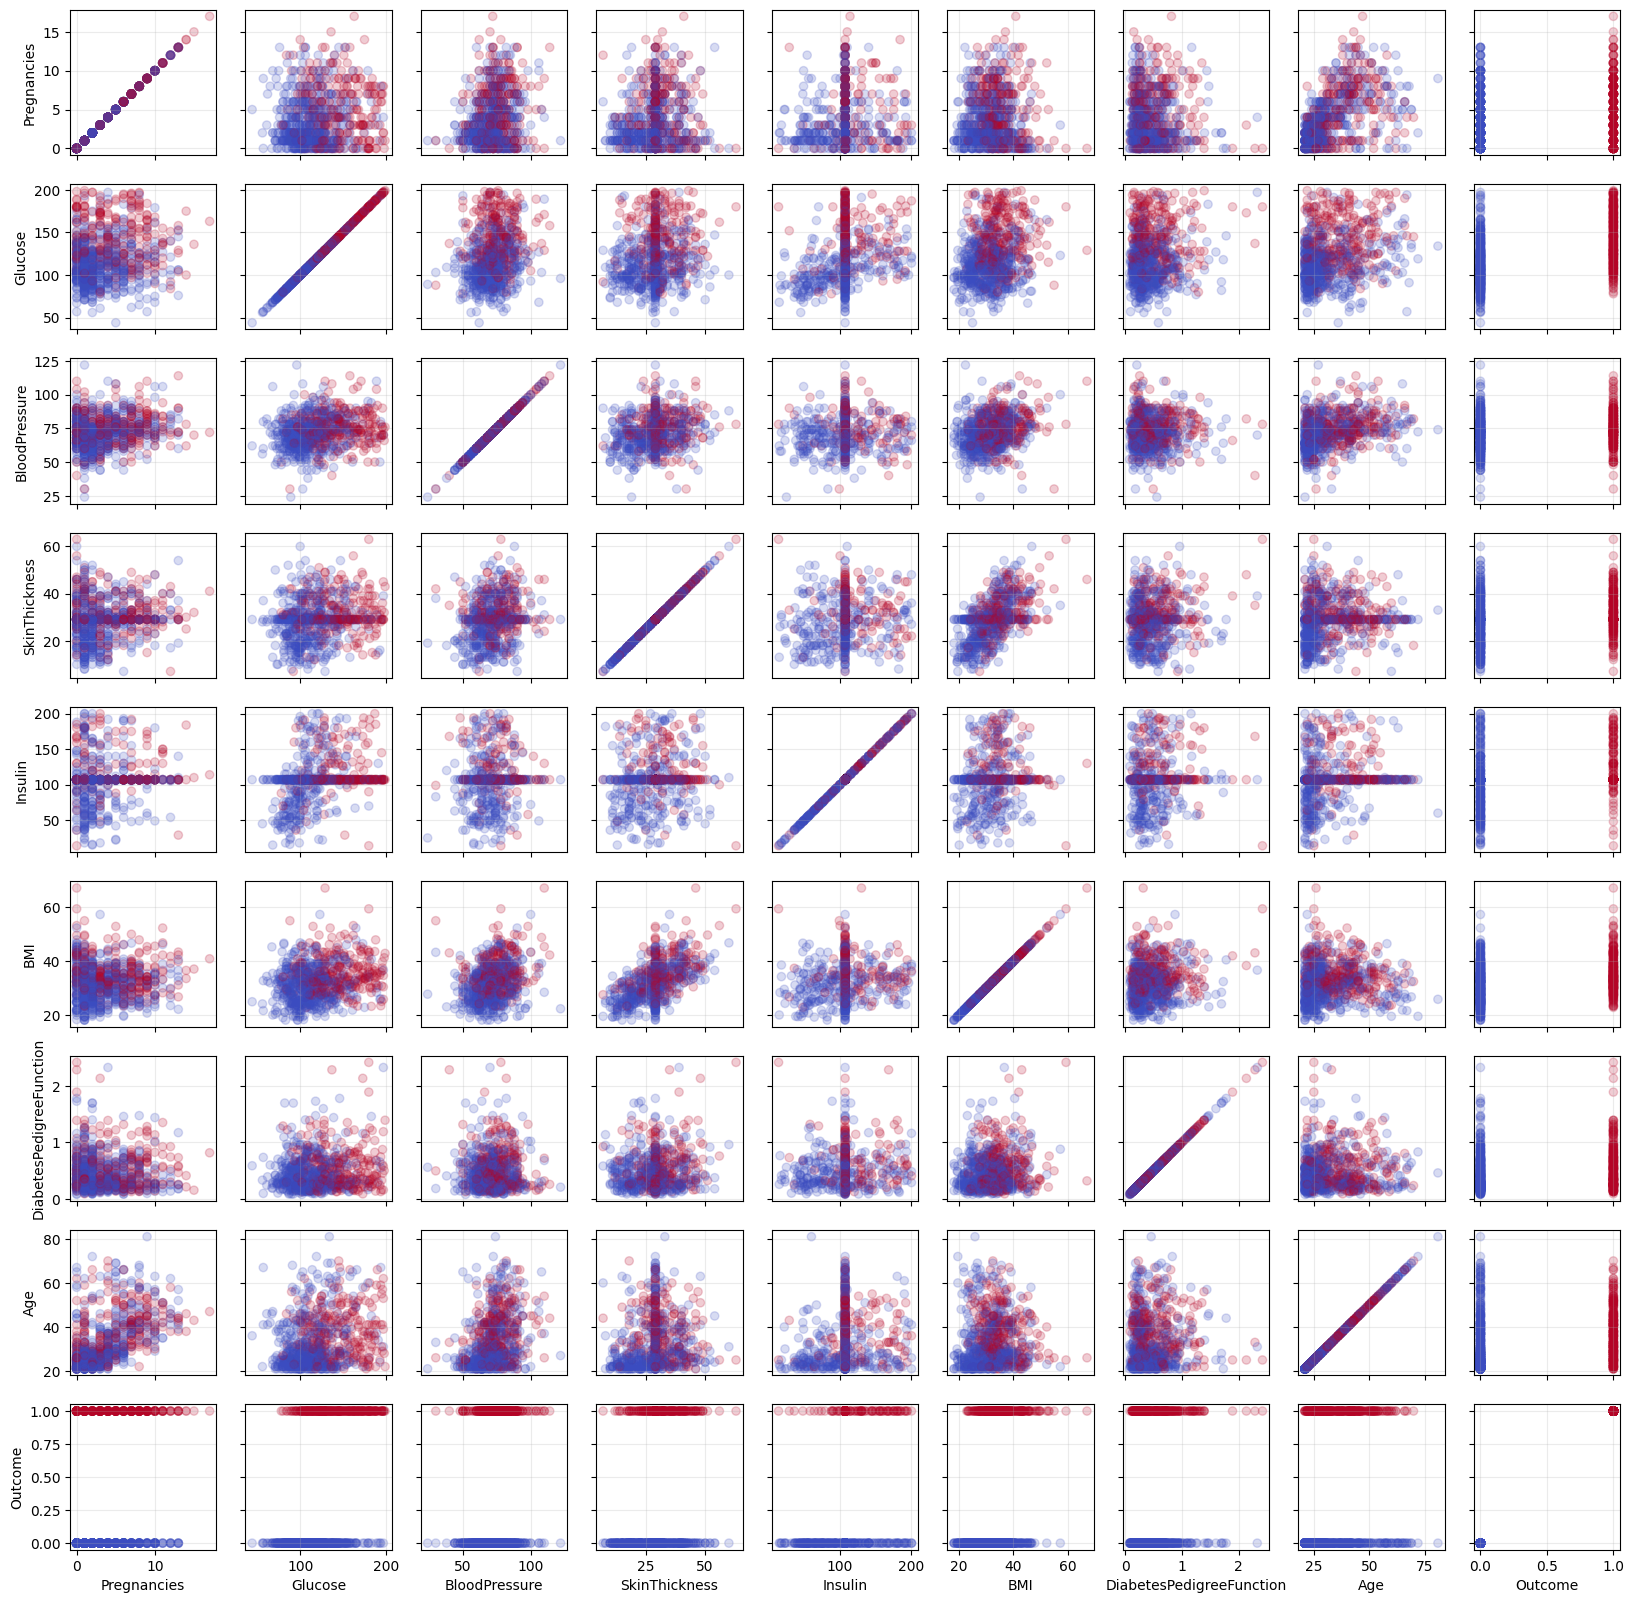

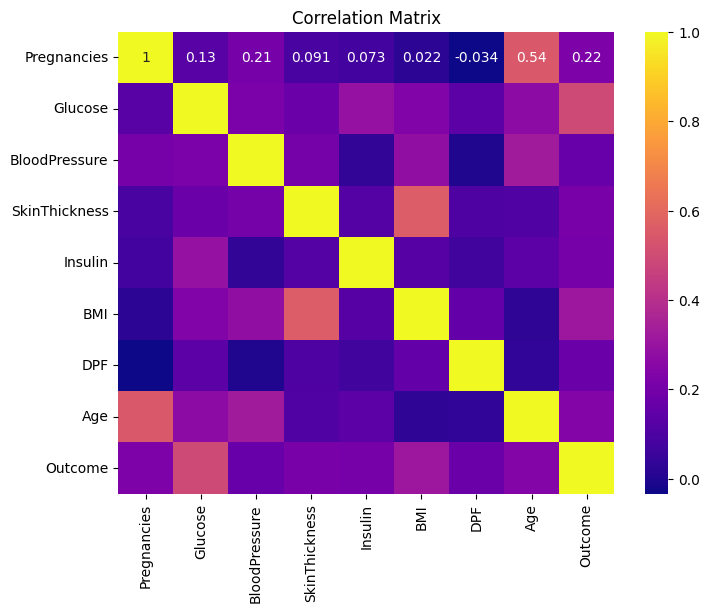

Outcome                     1.000000
Glucose                     0.492928
BMI                         0.311924
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.209607
Insulin                     0.206654
DiabetesPedigreeFunction    0.173844
BloodPressure               0.166074
Name: Outcome, dtype: float64


In [23]:
analyse_correlation(df=get_and_process_diabetes_df(processed=True))

We can see that there are some correlation between SkinThickness and BMI, and between Pregnancies and Age. 

Let's try to remove SkinThickness and Pregnancies.

Replacing 0 with Mean 121.6867627785059 (Mean value calculated excluding 0)
Replacing 0 with Mean 72.40518417462484 (Mean value calculated excluding 0)
Replacing 0 and values > 200 with Mean 107.07766990291262 (Mean value calculated excluding 0 and values > 200)
Replacing 0 with Mean 32.45746367239099 (Mean value calculated excluding 0)


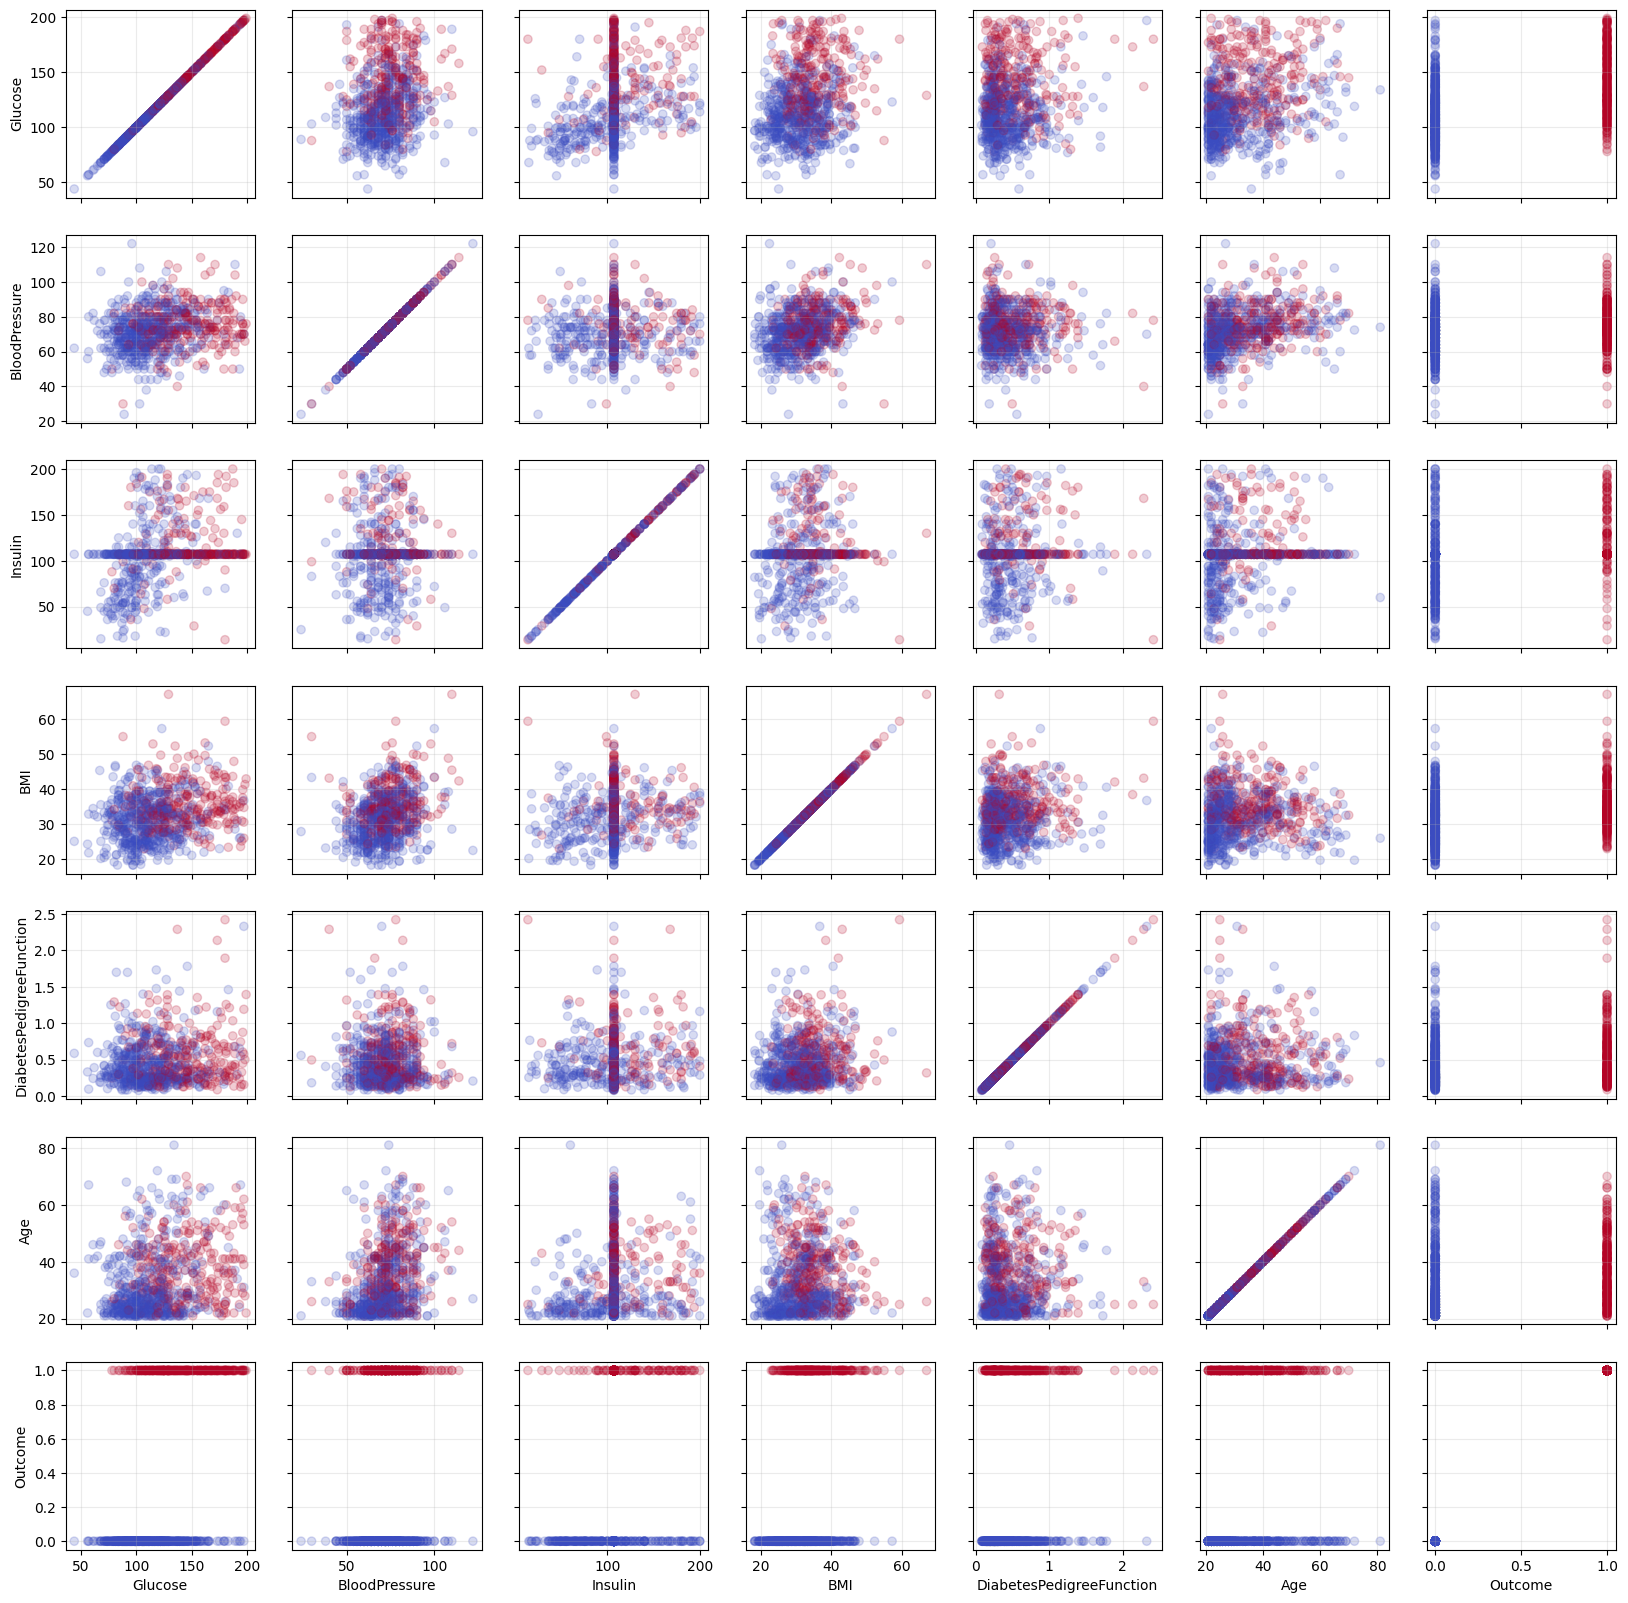

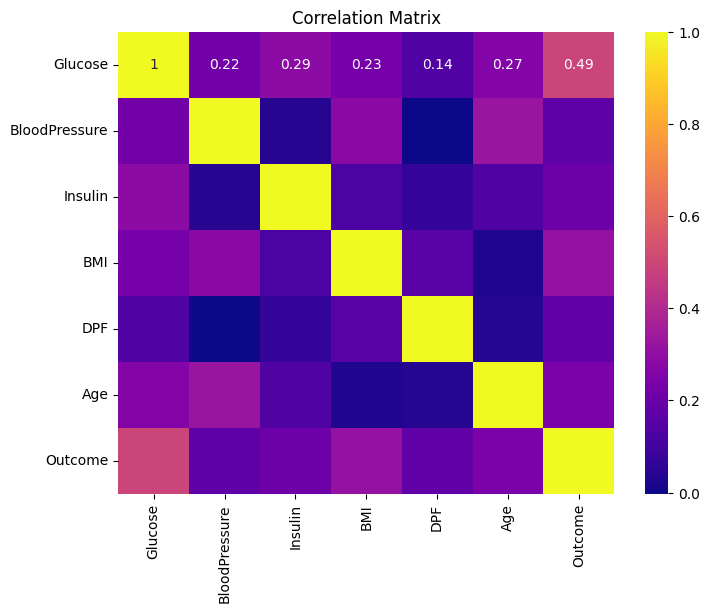

Outcome                     1.000000
Glucose                     0.492928
BMI                         0.311924
Age                         0.238356
Insulin                     0.206654
DiabetesPedigreeFunction    0.173844
BloodPressure               0.166074
Name: Outcome, dtype: float64


In [24]:
analyse_correlation(df=get_and_process_diabetes_df(features_to_drop=['SkinThickness', 'Pregnancies'], processed=True))

For this project, I will process the data and keep all the features for training.

### Preparing the data in numpy arrays for training

In [25]:
def convert_diabetes_data_to_numpy(df):
    column_names = df.columns.to_list()
    inputs = df[column_names[:-1]].to_numpy()
    binary_labels_int_1D_array = df[column_names[-1]].to_numpy().reshape(-1, 1)
    return inputs, binary_labels_int_1D_array, column_names


def test_load_processed_diabetes_data():
    unprocessed_inputs, unprocessed_binary_labels_int_1D_array, unprocessed_column_names = convert_diabetes_data_to_numpy(get_and_process_diabetes_df())
    processed_inputs, processed_binary_labels_int_1D_array, processed_column_names = convert_diabetes_data_to_numpy(get_and_process_diabetes_df(
        processed=True
    ))
    assert_array_equal(unprocessed_binary_labels_int_1D_array, processed_binary_labels_int_1D_array)

test_load_processed_diabetes_data()

Replacing 0 with Mean 121.6867627785059 (Mean value calculated excluding 0)
Replacing 0 with Mean 72.40518417462484 (Mean value calculated excluding 0)
Replacing 0 and 99 with Mean 29.024074074074075 (Mean value calculated excluding 0 and 99)
Replacing 0 and values > 200 with Mean 107.07766990291262 (Mean value calculated excluding 0 and values > 200)
Replacing 0 with Mean 32.45746367239099 (Mean value calculated excluding 0)


In [26]:
@cache
def get_diabetes_data():
    return convert_diabetes_data_to_numpy(get_and_process_diabetes_df(processed=True))

For this project, I will use the cached function to get the data instead of assigning to a global variable to avoid accidentally modifying the data. It is not good for performance when the data is large, but it is ok for this small dataset.

## Binary Logistic Regression with Gradient Descent

First we will try to build a logistic regression model to solve the diabetes binary classification problem.

### The building blocks of Binary Logistic Regression with Gradient Descent

#### Data Standardisation

Since our diabetes dataset is highly non-uniform, we will apply data standardisation before passing it to a learning model.

Standardisation helps make sure different features of objects are on almost the same scale, ensures that each feature is equally important and makes it easier to process by learning algorithms.

The following function will rescale the features to force the mean and standard deviation to be $0$ and $1$, respectively. 

More formally, for a data given by $\mathbf{X} = \left(
\left(\mathbf{x}^{(1)}\right)^{\top},\left(\mathbf{x}^{(2)}\right)^{\top},\ldots,\left(\mathbf{x}^{(s)}\right)^{\top}
\right) \in \mathbb{R}^{s\times d}$, we generate a new, rescaled data as:

$$
\hat{\mathbf{x}}^{(i)}_k = \frac{\mathbf{x}^{(i)}_k - \left\langle \mathbf{x}_k \right\rangle }{\left(\sigma_{\mathbf{x}}\right)_k},
$$

where $\left\langle \mathbf{x}_k \right\rangle = \frac{1}{s}\sum\limits_{j=1}^s \mathbf{x}^{(j)}_k$, and
$\left(\sigma_\mathbf{x}\right)_k = \sqrt{
	\frac{1}{s}\sum\limits_{j=1}^s \left(\mathbf{x}^{(j)}_k-\left\langle \mathbf{x}_k \right\rangle\right)^2}$
are the mean and standard deviation of the data vector $\mathbf{x}$.  

In addition, I will also write a function to reverse the standardisation process.

In [27]:
def standardise(data_matrix):
    row_of_means = np.mean(data_matrix, axis=0)
    standardised_matrix = data_matrix - row_of_means
    row_of_stds = np.std(data_matrix, axis=0)
    # print(f"row_of_stds: {row_of_stds}")
    # for i in range(len(row_of_stds)):
    #     if row_of_stds[i] == 0:
    #         row_of_stds[i] = 1
    return (standardised_matrix / row_of_stds), row_of_means, row_of_stds


def de_standardise(standardised_matrix, row_of_means, row_of_stds):
    matrix = np.copy(standardised_matrix * row_of_stds)
    return matrix + row_of_means



def test_standardising_data():
    test_data_matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    test_standardise_data_matrix = np.array(
        [
            [-1.224745, -1.224745, -1.224745],
            [0.0, 0.0, 0.0],
            [1.224745, 1.224745, 1.224745],
        ]
    )
    test_row_of_means = np.array([4, 5, 6])
    test_row_of_stds = np.array(np.sqrt([6, 6, 6]))
    (
        test_result_standardise_data_matrix,
        test_result_row_of_means,
        test_result_row_of_stds,
    ) = standardise(test_data_matrix)
    assert_array_almost_equal(
        test_result_standardise_data_matrix, test_standardise_data_matrix
    )
    assert_array_almost_equal(test_result_row_of_means, test_row_of_means)
    assert_array_almost_equal(test_result_row_of_stds, test_row_of_stds)

test_standardising_data()

#### Get Linear Regression Data

Given a NumPy array *`data_inputs`* which is a data matrix containing all inputs in matrix form as follows

$$
\mathbf{X} = 
\begin{pmatrix}
x^{(1)}_1 & x^{(1)}_2 & \ldots & x^{(1)}_d \\
x^{(2)}_1 & x^{(2)}_2 & \ldots & x^{(2)}_d \\
\vdots & \vdots & \ddots & \vdots & \\
x^{(s)}_1 & x^{(s)}_2 & \ldots & x^{(s)}_d \\
\end{pmatrix},
$$

the next function will output the linear regression data matrix defined as

$$
\mathbf{\Phi\left(X\right)} = 
\begin{pmatrix}
1 & x^{(1)}_1 & x^{(1)}_2 & \ldots & x^{(1)}_d \\
1 & x^{(2)}_1 & x^{(2)}_2 & \ldots & x^{(2)}_d \\
\vdots & \vdots & \vdots & \ddots & \vdots & \\
1 & x^{(s)}_1 & x^{(s)}_2 & \ldots & x^{(s)}_d \\
\end{pmatrix}.
$$

In short, the function will add a column of ones to the front the input data matrix.

In [28]:
# Add a column of 1's to the front of the data matrix
def linear_regression_data(data_inputs):
    first_column = np.ones((len(data_inputs), 1))
    X_matrix = np.c_[first_column, data_inputs]
    return X_matrix

#### Gradient descent

The following function performs gradient descent to numerically approximate a minimiser of a convex function according to the update rule:

$
\mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \tau \nabla E\left(\mathbf{w}^{(k)}\right), \quad k\geq 0,
$

where $E\left(\mathbf{w}\right): \mathbb{R}^n \to \mathbb{R}$ is the real valued, convex, differentiable energy function of $n$-dimensional argument $\mathbf{w}=\left(w_1,w_2,\ldots,w_n\right)$ and $\tau > 0$ is the step-size.

It takes the following arguments:
- *`objective_function`* - the energy function $E$ which takes a NumPy array and returns a real number.
- *`compute_gradient`* - the function $\nabla E$ which takes a NumPy array and returns a NumPy array representation of the gradient.
- *`initial_weights`* - a NumPy array with initial values $\mathbf{w}^{(0)}$ for the first iteration
- *`step_size`* - the step-size parameter $\tau$ for the gradient descent step
- *`no_of_iterations`* - the number of iterations
- *`print_output`* - how often an intermediate result is printed. *`print_output` = k* means that a result is printed after every $k$ iterations.

and returns a NumPy array of the weights obtained after gradient descent together with a list of objective values of all iterations

In [29]:
def gradient_descent(
        objective_function,
        compute_gradient,
        initial_weights,
        step_size=1, no_of_iterations=100,
        print_output=None
):
    objective_values = []
    weights = np.copy(initial_weights)
    objective_values.append(objective_function(weights))

    for counter in range(no_of_iterations):
        gradients = compute_gradient(weights)
        update = step_size * gradients
        weights -= update
        objective_values.append(objective_function(weights))
        if print_output is not None:
            if (counter + 1) % print_output == 0:
                print("Iteration {k}/{m}, objective = {o}.".format(k=counter+1,m=no_of_iterations,
                                                                o=objective_values[counter]))
    if print_output is not None:
        print("Iteration completed after {k}/{m}, objective = {o}.".format(k=counter+ 1,
                                                                       m=no_of_iterations,
                                                                       o=objective_values[counter]))
    return weights, objective_values



def test_compute_gradient_descent():
    test_matrix_m = np.array([[3, 1], [2, 4]])
    test_vector_v = np.array([5, 6])
    # let us consider the usual E(x) function
    test_objective = lambda x: x.T @ (test_matrix_m @ x) + x @ test_vector_v
    #we know the gradient
    test_gradient = lambda x: (test_matrix_m + test_matrix_m.T) @ x + test_vector_v

    test_initial_weights = np.array([0.0, 0.0])
    test_step_size = 0.9 / (np.linalg.norm(test_matrix_m + test_matrix_m.T))
    test_no_of_iterations = 100
    test_print_output = 10
    assert_array_almost_equal(gradient_descent(test_objective, test_gradient, \
                                            test_initial_weights,test_step_size,\
                                            test_no_of_iterations, test_print_output)[0],np.array([-0.564103, -0.538462]))

test_compute_gradient_descent()

Iteration 10/100, objective = -3.0256011293288547.
Iteration 20/100, objective = -3.0256410067129824.
Iteration 30/100, objective = -3.025641025632046.
Iteration 40/100, objective = -3.0256410256410216.
Iteration 50/100, objective = -3.025641025641026.
Iteration 60/100, objective = -3.0256410256410255.
Iteration 70/100, objective = -3.0256410256410255.
Iteration 80/100, objective = -3.0256410256410255.
Iteration 90/100, objective = -3.025641025641025.
Iteration 100/100, objective = -3.0256410256410255.
Iteration completed after 100/100, objective = -3.0256410256410255.


#### Logistic function

The following function implements the $\sigma(x)$ sigmoid function 

$
\sigma(x): = \frac{1}{1+\mathrm{e}^{-x}} \, , 
$

applied to the *`inputs`* $x$.

In [30]:
def logistic_function(inputs):
    return 1 / (1 + np.exp(-inputs))



def test_logistic_function():
  test_inputs = np.array([[0], [np.log(25)], [-6], [np.log(9)], [2]])
  assert_array_almost_equal(logistic_function(test_inputs), np.array([[1/2], [25/26], [0.0024726231566347743], \
                              [9/10], [(np.exp(2))/(1 + np.exp(2))]]))

  test_inputs = np.array([-1, 0, 1])
  assert_array_almost_equal(logistic_function(test_inputs),
                            np.array([0.26894142, 0.5, 0.73105858]))

test_logistic_function()

#### Model function

This function takes two arguments `data_matrix` and `weights` and outputs the values of the model function $f\left(\mathbf{x},\mathbf{w}\right) = \left\langle \phi\left(\mathbf{x}\right),\mathbf{w} \right\rangle$ evaluated for all data samples $\mathbf{x}_i, \quad i=\overline{1,s}$.

In [31]:
def model_function(data_matrix, weights):
    return data_matrix @ weights

#### Binary prediction function

This function combines the logistic function and the model function to calculate the probability that each of the labels is $1$, and outputs the binary prediction of the model for all data points $\mathbf{x}_i, \quad i=\overline{1,s}$ according to a fixed threshold which is set here as $0.5$.

In [32]:
def binary_prediction_function(data_matrix, weights):
    # the binary classification can be obtained by applying the logistic function to the predicted ys i.e., Xw
    # in this first implementation we use classic regression first then use the logistic function later
    probability = logistic_function(model_function(data_matrix, weights))
    return probability > 1/2



def test_binary_prediction_function():
    test_inputs = np.array([[1, 2, 3]])
    test_weights = np.array([[-1, 1], [2, 2], [-3, 3], [4, 4]])
    test_data_matrix = linear_regression_data(test_inputs)
    assert_array_almost_equal(binary_prediction_function(test_data_matrix, test_weights),
                                np.array([[True, True]]))  # True means 1

    test_data_matrix = np.array([[1, -1, 2, -3], [1, 0, 2, 4], [1, -3, 0, 5]])
    test_weights = np.array([[2], [0], [1], [-1]])
    assert_array_almost_equal(
        binary_prediction_function(test_data_matrix, test_weights),
        np.array([[1], [0], [0]]))  # 0 means False


test_binary_prediction_function()

#### Binary logistic regression cost function

The cost function for binary logistic regression is defined as

$
\mathrm{L}\left(\mathbf{w}\right) = \frac{1}{s} \left(
\sum\limits_{i=1}^s \log\left[1+\exp\left(f\left(\mathbf{x}^{(i)},\mathbf{w}\right)\right)\right] - y_i\cdot f\left(\mathbf{x}^{(i)},\mathbf{w}\right)
\right),
$

where $\mathbf{x}^{(i)}$ is a vector representing $i$-th data sample and $f$ is the model function. 

The cost function takes the NumPy arrays `data_matrix`, `data_labels` and `weights` as arguments. 

In [33]:
def binary_logistic_regression_cost_function(data_matrix, data_labels, weights):
    regression_outputs = model_function(data_matrix, weights)
    # Week 9, Slide 25
    return np.mean(np.log(1 + np.exp(regression_outputs)) - data_labels * regression_outputs)


def test_binary_logistic_regression_cost_function():
  test_data_matrix = np.array([[1, -1, 2, -3], [1, 0, 2, 4], [1, -3, 0, 5]])
  test_data_labels = np.array([[1], [0], [0]])
  test_weights = np.array([[2], [0], [1], [-1]])
  assert_array_almost_equal(binary_logistic_regression_cost_function(test_data_matrix,
                                              test_data_labels, test_weights),0.24754867)

test_binary_logistic_regression_cost_function()

#### Binary logistic regression gradient

In the case of linear model function $f\left(\mathbf{x},\mathbf{w}\right) = \left\langle \phi\left(\mathbf{x}\right),\mathbf{w} \right\rangle$ we have the gradient formula

$
\nabla \mathrm{L}\left(\mathbf{w}\right) = \frac{1}{s} \left(
\sum\limits_{i=1}^s \phi\left(\mathbf{x}^{(i)}\right)\cdot\sigma
\left(\left\langle \phi\left(\mathbf{x}^{(i)}\right),\mathbf{w} \right\rangle \right) - y_i\cdot \phi\left(\mathbf{x}^{(i)}\right)
\right),
$

with $\phi\left(\mathbf{x}^{(i)}\right)$ being an augmented $i$-th data vector containing additional coordinate $1$.

The following function takes the same inputs as $\mathtt{binary\_logistic\_regression\_cost\_function}$ and computes the gradient of the binary logistic regression cost function as defined in the lecture.

In [34]:
def compute_binary_logistic_regression_gradient(data_matrix, data_labels, weights):
    num_data_rows = len(data_matrix)
    z = model_function(data_matrix, weights)
    predictions = logistic_function(z)
    difference = predictions - data_labels
    gradient = (data_matrix.T @ difference) / num_data_rows
    return gradient

def binary_logistic_regression_gradient(data_matrix, data_labels, weights):
    return data_matrix.T @ (logistic_function(model_function(data_matrix, weights)) - data_labels) / len(data_matrix)


def test_compute_binary_logistic_regression_gradient():
    test_data_matrix = np.array([[1, -1, 2, -3], [1, 0, 2, 4], [1, -3, 0, 5]])
    test_data_labels = np.array([[1], [0], [0]])
    test_weights = np.array([[2], [0], [1], [-1]])
    assert_array_almost_equal(compute_binary_logistic_regression_gradient(test_data_matrix,test_data_labels,test_weights), \
                            np.array([[0.182172],[-0.047122],[0.332726], [0.746621]]))

test_compute_binary_logistic_regression_gradient()

#### Train

We are now ready to stat training the model. To be able to reuse the code, I will define the following function which takes

- `data_matrix_X` - a NumPy array containing the data matrix $\mathbf{X}$,
- `true_labels_y` - a NumPy array containing the true labels $\mathbf{y}$,
- `step_size` - the step-size parameter $\tau$ for the gradient descent step,
- `no_of_iterations` - the number of iterations,
- `print_output` - how often an intermediate result is printed during gradient descent. *`print_output` = k* means that a result is printed after every $k$ iterations.

It returns the output of the gradient descent function which are a NumPy array of the weights obtained after gradient descent together with a list of objective values of all iterations.

In [35]:
def train_binary_logistic_regression_classification_model(data_matrix_X, true_labels_y, step_size, no_of_iterations=1000, print_output=1000):

    # we then define the cost function. Here I use the binary logistic regression cost function
    cost_function = lambda weights: binary_logistic_regression_cost_function(
        data_matrix_X,
        true_labels_y,
        weights
    )

    # then we get the gradient
    gradient_function = lambda weights: compute_binary_logistic_regression_gradient(
        data_matrix_X,
        true_labels_y,
        weights
    )

    # start with w^0 = 0
    initial_weights = np.zeros((len(data_matrix_X.T), 1))

    # apply gradient descent
    optimal_weights, objective_values = gradient_descent(
        cost_function,
        gradient_function,
        initial_weights,
        step_size,
        no_of_iterations=no_of_iterations,
        print_output=print_output
    )

    return optimal_weights, objective_values

#### F1 Score

We found out that our dataset is imbalanced. More specifically, the number of $0$ labels is higher than that of $1$ labels. Therefore, in addition to accuracy, I will also use the F1 score to evaluate the model, as it is less prevalence-dependent. See https://en.wikipedia.org/wiki/F1_score.

In [36]:
def compute_f1_score(estimated_labels, true_labels):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for i in range(len(estimated_labels)):
        if estimated_labels[i] == true_labels[i] == 1:
            true_positive += 1
        elif estimated_labels[i] == 1 and true_labels[i] == 0:
            false_positive += 1
        elif estimated_labels[i] == 0 and true_labels[i] == 1:
            false_negative += 1
        else:
            true_negative += 1
    if true_positive == 0: return 0
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


def test_compute_f1_score_compared_to_sklearn():
    # Binary data only, 5 points each
    test_estimated_labels = np.array([0,1,1,1,1,0,0,0,0,1,1,0,1,0,1,1])
    test_true_labels = np.array([1,1,1,0,0,1,1,1,0,0,1,0,1,0,0,1])
    assert_array_almost_equal(
        compute_f1_score(test_estimated_labels, test_true_labels), 0.555556)

    from sklearn.metrics import f1_score
    sklearn_f1_score = f1_score(test_true_labels, test_estimated_labels)
    assert_array_almost_equal(
        sklearn_f1_score, 0.555556)

test_compute_f1_score_compared_to_sklearn()

### K-Fold Cross Validation

Here I will implement a number of functions to carry out K-fold cross validation which can be summarised as follows:

1. split the data, joined inputs and outputs, into $K$ approximately equal chunks. Let us call them $D_1, D_2, \ldots, D_K$;

2. for every $i = 1,\ldots,K$ evaluate optimal weights/coefficients $\mathbf{W}_i$ for the logistic regression evaluated over the data set $D_1,D_2,\ldots,D_{i-1},D_{i+1},\ldots,D_K$ and a corresponding validation error $L_i$ evaluated over the set $D_i$;

3. evaluate average of optimal weights 
$\hat{\mathbf{W}} = \frac{1}{K}\left(\mathbf{W}_1+\mathbf{W}_2+\ldots+\mathbf{W}_K\right)$ and an average validation error 
$L = \frac{1}{K}\left(L_1+L_2+\ldots+L_K\right)$.

#### K-Fold Split

The following function takes two arguments *data_size* and *K* and outputs a random split of integer indexes $\left[0,1,\ldots,data\_size\right)$ into $K$ almost equal chunks. For example, for $K=2$ and $data\_size = 5$ it may return $[[3,0],[2,4,1]]$.

In [37]:
def KFold_split(data_size, K):
    indexes = np.random.permutation(data_size)
    m, r = divmod(data_size, K) # m is the quotient and r the reminder of the division data_size/K
    indexes_split = [indexes[i * m + min(i, r):(i + 1) * m + min(i + 1, r)] for i in range(K)]

    return indexes_split



def test_KFold_split():
    test_data_size = np.random.randint(low=1, high=10)
    test_K = np.random.randint(low=1, high=5)
    print (test_data_size,test_K )
    indexes_split = KFold_split(test_data_size, test_K)
    print (indexes_split)
    data_indexes = np.array([])
    for i in range(test_K):
        data_indexes = np.append(data_indexes, indexes_split[i])
    data_indexes = np.sort(data_indexes)
    assert_array_almost_equal(data_indexes, np.array(range(test_data_size)))

test_KFold_split()

4 4
[array([2]), array([0]), array([1]), array([3])]


#### Print Confusion Matrix

Before moving on to actually training with K-fold cross validation, I will define a function to print the confusion matrix. Since this is a binary classification on an imablanced dataset, it is usually helpful to look at the confusion matrix to have a feel of how well the classifier does.

[[1 3]
 [4 2]]


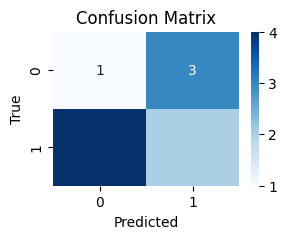

In [38]:
def print_confusion_matrix(predicted_labels, true_labels):
    confusion_matrix = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)
    print(confusion_matrix)  # Print the numbers in the confusion matrix

    fig, ax = plt.subplots()
    fig.set_size_inches(w=3,h=2)
    sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g') # Plot confusion matrix as a heatmap
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show();



def test_print_confusion_matrix():
    test_predicted_labels = np.array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1])
    test_true_labels = np.array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0])
    print_confusion_matrix(test_predicted_labels, test_true_labels)

test_print_confusion_matrix()

#### Train Binary Logistic Regression with K-Fold Cross Validation

In order to reuse the code for later experiments with other learning algorithms, I have tried to write a general function that takes a classifier object which represents a learning algorithm, as well as the data for training.

Before that, I will define a couple of classes that will help make the code more generalised.

##### Class `BinaryLogisticRegressionClassifier`

This class uses the binary logistic regression function as described above.

In [39]:
class BinaryLogisticRegressionClassifier():
    def __init__(self, params, no_of_iterations=10000, print_output=None):
        self.params = params
        self.no_of_iterations = no_of_iterations
        self.print_output = print_output

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        step_size = self.params['step_size']
        optimal_weights, objective_values = train_binary_logistic_regression_classification_model(
            data_matrix_X=X, true_labels_y=y,
            step_size=step_size,
            no_of_iterations=self.no_of_iterations, print_output=self.print_output
        )
        optimal_weights = optimal_weights.reshape(-1)
        self.coef_ = optimal_weights

    def predict(self, X):
        predicted_labels = binary_prediction_function(X, self.coef_)
        return predicted_labels

##### Class `WeightsProcessor`

Since I will be comparing models that use weights, namely logistic regression and SVM, I want to get the weights to do some interpretation and rank the importance of the features. However, I will also be using K-fold cross validation which will not calculate any weights. Therefore, I have defined a logic to takes an object which can either process the weights during the K-fold cross validation or not. Here, I will define the class for objects which take the weights at each fold and calculate the final average weights.

In [40]:
class WeightsProcessor:
    def __init__(self): self.reset()
    def reset(self): self.optimal_weights = None

    def compute_and_save_results(self, classifier, k_splits):
        # the weights are also averaged across the splits
        weights = classifier.coef_.ravel()
        if self.optimal_weights is None:
            self.optimal_weights = weights / k_splits
        else:
            self.optimal_weights += weights / k_splits

    def print_results(self):
        print("Optimal weights: {w}".format(w=self.optimal_weights))

##### K-Fold Cross Validation

Now we are ready to train the model using K-fold cross validation. This is the general function that takes a classifier object and the data for training. In the case of logistic regression, using the logic of the `WeightsProcessor` class, we can also extract the average weights for future interpretation and ranking of features.

In [41]:
def KFold_cross_validate(
        data_matrix_X,
        data_labels,
        k_splits,
        classifier,
        result_processor,
        shows_confusion_matrix=False,
        shows_metrics=False
):
    data_size = len(data_matrix_X)
    np.random.seed(123456789) # Set random state for reproducibility

    indexes_split = KFold_split(data_size, k_splits)

    average_metrics = None
    metric_names = ["Accuracy rate", "F1 score", "Precision", "Recall"]

    # each indexes_split[j] is an array with the ids of the data matrix for that split
    # all the others ids can be used for training and the j for validation
    for i in range(k_splits):
        # hence this concatenates all the ids of the data matrix EXCEPT for those in the i split
        # those are used for validation!
        indexes = np.concatenate([indexes_split[j] for j in range(k_splits) if (j != i)])

        X_train, X_validate = data_matrix_X[indexes], data_matrix_X[indexes_split[i]]
        y_train, y_validate = data_labels[indexes], data_labels[indexes_split[i]]

        classifier.fit(X_train, y_train.ravel())
        # training the model in all the data EXCEPT for the i split
        y_predicted = classifier.predict(X_validate)
        # the error is computed OUT OF SAMPLE in the i split
        accuracy_rate = sklearn.metrics.accuracy_score(y_predicted, y_validate)
        # f1_score = sklearn.metrics.f1_score(y_predicted, y_validate)
        f1_score = compute_f1_score(y_predicted, y_validate)
        precision = sklearn.metrics.precision_score(y_predicted, y_validate)
        recall = sklearn.metrics.recall_score(y_predicted, y_validate)

        # ### F1 score
        # Accuracy is not always a good measure when the data is unbalanced. For example, in our case, since about 65% of people do not have diabetes, a model that always predicts "no diabetes" will be accurate about 65% of the time.
        # The F1 score is the harmonic mean of precision and recall. It is a better measure than accuracy when the data is unbalanced.

        metrics_set = np.array([accuracy_rate, f1_score, precision, recall])

        result_processor.compute_and_save_results(classifier, k_splits)

        # # then the overall performance is measured as the average of the error for each split
        if (i == 0):
            average_metrics = metrics_set / k_splits
        else:
            average_metrics += metrics_set / k_splits

        if i == 0 and shows_confusion_matrix:
            print(f"Confusion matrix for split {i}:")
            print_confusion_matrix(predicted_labels=y_predicted, true_labels=y_validate)

    if shows_metrics:
        result_processor.print_results()
        print("\nMean values of metrics:")
        df = pd.DataFrame([average_metrics], columns=metric_names)
        print(df)

    return average_metrics

##### Run K-Fold Cross Validation on diabetes dataset

The following function runs the K-fold cross validation on the diabetes dataset using a given classifier algorithm. I will use $K=5$ for the number of fold.

In [42]:
def KFold_with_diabetes_data(method, classifier, result_processor, shows_confusion_matrix=True, shows_metrics=True):
    print(f"\n ------------------ \n Using {method} \n ------------------ \n")
    non_standardised_data_inputs, data_labels, column_names = get_diabetes_data()
    standardised_data_inputs, row_of_means, row_of_stds = standardise(non_standardised_data_inputs)
    data_matrix_X = linear_regression_data(standardised_data_inputs)
    KFold_cross_validate(
        data_matrix_X=data_matrix_X,
        data_labels=data_labels,
        k_splits=5,
        classifier=classifier,
        result_processor=result_processor,
        shows_confusion_matrix=shows_confusion_matrix,
        shows_metrics=shows_metrics
    )

Let's run the K-fold cross validation on the diabetes dataset using the binary logistic regression classifier. I will use a step size of $0.01$.

In [43]:
KFold_with_diabetes_data(
    method='my implementation of Logistic Regression',
    classifier=BinaryLogisticRegressionClassifier({'step_size' : 0.01}, no_of_iterations=10000, print_output=None),
    result_processor=WeightsProcessor()
)


 ------------------ 
 Using my implementation of Logistic Regression 
 ------------------ 

Replacing 0 with Mean 121.6867627785059 (Mean value calculated excluding 0)
Replacing 0 with Mean 72.40518417462484 (Mean value calculated excluding 0)
Replacing 0 and 99 with Mean 29.024074074074075 (Mean value calculated excluding 0 and 99)
Replacing 0 and values > 200 with Mean 107.07766990291262 (Mean value calculated excluding 0 and values > 200)
Replacing 0 with Mean 32.45746367239099 (Mean value calculated excluding 0)
Confusion matrix for split 0:
[[87 15]
 [21 31]]


Optimal weights: [-0.88618659  0.42136246  1.06950188 -0.0838851   0.01831689  0.19534816
  0.62146407  0.27419115  0.15021274]

Mean values of metrics:
   Accuracy rate  F1 score  Precision    Recall
0       0.768254  0.632143   0.571292  0.710268


We can see the average performance report above. The average accuracy is about $0.77$ and the average F1 score is about $0.63$. This is not a bad result considering that the dataset is small.

For comparison, I will also run the same experiment using a logistic regression implementation from scikit-learn.

In [44]:
KFold_with_diabetes_data(
    method='sklearn LogisticRegression',
    classifier=sklearn.linear_model.LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000),
    result_processor=WeightsProcessor()
)


 ------------------ 
 Using sklearn LogisticRegression 
 ------------------ 

Confusion matrix for split 0:
[[87 15]
 [21 31]]


Optimal weights: [-0.44317819  0.42166077  1.06976424 -0.08424246  0.01755575  0.19526436
  0.62247522  0.27422548  0.15027041]

Mean values of metrics:
   Accuracy rate  F1 score  Precision    Recall
0       0.768254  0.632143   0.571292  0.710268


We can see that, even though the optimal weights calculated here are different from what my implementation found, the performance of the two implementations are the same. This gives me confidence that my implementation is correct.

In the following section, I will perform grid search to try to tune the hyperparameters to see if I can improve the performance.

### Grid Search

Similar to the above strategy, I will define a general function to perform grid search on for any given learning algorithm and a set of hyperparameters. To do this, instead of taking a grid of values for the hyperparameter, it will take a list of classifiers, each already initialised with a different hyperparameter value. It will return a list of performance metrics corresponding to the different hyperparameter values. The metric I use here is the average F1 score from the K-fold cross validation.

In [45]:
def grid_search(grid_classifiers, result_processor, data_matrix_X, data_output, K_folds=5, verbose=False):
    values = np.array([])
    for classifier in grid_classifiers:
        if verbose:
            start_time_seconds = time.time()
            print(f'Classifier: {classifier}')

        result_processor.reset()
        metrics = KFold_cross_validate(
            data_matrix_X=data_matrix_X,
            data_labels=data_output,
            k_splits=K_folds,
            classifier=classifier,
            result_processor=result_processor,
            shows_confusion_matrix=False,
            shows_metrics=False
        )
        values = np.append(values, metrics[1])  # F1 score

        if verbose:
            end_time_seconds = time.time()
            elapsed_time_seconds = end_time_seconds - start_time_seconds
            print(f'Elapsed time: {elapsed_time_seconds:.2f} seconds')
            print('-------------------')

    return values

Now let's put it all together into a function. This function will return the best classifier, the best hyperparameter value and the highest F1 score.

In [46]:
def run_grid_search(
    grid_classifiers,
    grid,
    result_processor,
    K_folds=5,
    verbose=False
  ):
  non_standarded_data_inputs, data_output, column_names = get_diabetes_data()
  standardised_data_inputs, row_of_means, row_of_stds = standardise(non_standarded_data_inputs)
  data_matrix_X = linear_regression_data(standardised_data_inputs)
  f1_scores = grid_search(
    grid_classifiers=grid_classifiers,
    result_processor=result_processor,
    data_matrix_X=data_matrix_X,
    data_output=data_output,
    K_folds=K_folds,
    verbose=verbose
  )

  # least_error_index = np.argmin(errors)
  least_error_index = np.argmax(f1_scores)
  # row with max element index 1

  if verbose:
    print(f'Best number of neighbours: {grid[least_error_index]}')
    print(f'Error: {f1_scores[least_error_index]}')

  return grid_classifiers[least_error_index], grid[least_error_index], f1_scores[least_error_index]

I will start with the binary logistic regression classifier and try to tune the step size. I will try the set of values $\{0.01, 0.1, 0.5, 1.0, 2.0\}$. Please note that this might take a while to run.

In [47]:
run_grid_search(
    grid_classifiers=[BinaryLogisticRegressionClassifier({'step_size': step_size}, no_of_iterations=10000, print_output=None) for step_size in [0.01, 0.1, 1, 10]],
    grid=[0.01, 0.1, 1, 10],
    result_processor=WeightsProcessor(),
)

(<__main__.BinaryLogisticRegressionClassifier at 0x12b263940>,
 0.01,
 0.6321430970651962)

The final result shows that the best step size is $0.01$ which is the same value that we used previously.

### Bootstrap Sampling

We can use the values of the weights to judge whether a feature is important or not. Let's assume that the larger the absolute value of the weight, the more important the feature is. To have more confidence, we will use bootstrap sampling to calculate multiple sets of weights and see their distribution.

In [48]:
def bootstrap_regression(classifier, standardised_data_input,standardised_data_output,fraction,M):
    # first we need to know what is N: the number of samples to extract
    data_size=len(standardised_data_output)
    samples_size=int(data_size*fraction)
    print(f"samples_size = {samples_size}")

    random.seed(123456789)  # for reproducibility

    w_list=[]
    # then for each of the M extract
    for j in range(M):
        sample_input_list=[]
        sample_output_list=[]
        for i in range(samples_size):
            # we take N samples extract random numbers which are the id of the arrays that store the data
            # id_random=random.randint(0,samples_size-1)  # This will only select the first 90% of the data
            id_random = random.randint(0, data_size - 1)
            # note that we need to keep the X and Y correspondence hence the id_random is the same for each
            sample_input_list.append(standardised_data_input[id_random])
            sample_output_list.append(standardised_data_output[id_random])

        # convert the list to arrays
        sample_input=np.array(sample_input_list)
        sample_output=np.array(sample_output_list)

        # apply the regression, note that alpha is selected before with the model selection
        # weights=ridge_regression(sample_input, sample_output, regularisation=alpha)

        classifier.fit(sample_input, sample_output)
        weights = classifier.coef_.ravel()

        # append the fitted values of Ws for the N samples in list
        weights_simple_1D_array = np.reshape(weights, (len(weights),))  # Convert to 1D array to be compartible with indexing
        w_list.append(weights_simple_1D_array)

    # print(f"w_list.shape = {np.array(w_list).shape}")
    return w_list

In [49]:
def do_bootstrap(classifier, non_standardised_input, binary_labels_int_column_vector, column_names):
    features = column_names[:-1]  # drop the target column

    standardised_data_input, row_of_means, row_of_stds = standardise(non_standardised_input)

    binary_labels_int_simple_1D_array = np.reshape(binary_labels_int_column_vector, (len(binary_labels_int_column_vector),))  # Convert to 1D array to be compartible with indexing

    # M=10000  # Took too long...
    M=100
    # note how the alpha is selected in the model selection before!
    step_size=0.01 # TODO: grid search to find optimal step size
    w_list=bootstrap_regression(
        classifier,
        standardised_data_input,
        binary_labels_int_column_vector,
        0.9,
        M)

    # now we have a list with all the values of w for each of the M samples
    # we can create a dictionary to get the values for each features
    dict_w={}
    for i in range(len(features)):
        dict_w[i]=[]

    # append the values to each feature as list
    for i in range(M):
        w=w_list[i]
        for j in range(len(w)):
            dict_w[j].append(w[j])

    # print(f"dict_w = {dict_w}")

    for i in dict_w:
        dict_w[i]=np.array(dict_w[i]) # first convert the list into a nunpy array then we can manipulate them
        print (features[i],np.mean(dict_w[i])) # get for example the mean

    return w_list, features

def demo_bootstrap():
    non_standardised_input, binary_labels_int_column_vector, column_names = get_diabetes_data()
    w_list, features = do_bootstrap(non_standardised_input, binary_labels_int_column_vector, column_names)

In [50]:
# we can then use seaborn to plot, this requires pandas
# let us first create the data for the df
# this function takes the features and the list of w from the bootstrap, it write the data into a file for simplicity
import pandas as pd

def save_weights_list_and_get_df(features, w_list):
    # let's first create the headers of the file
    a=open('weights_list.csv','w')
    for j in range(len(features)-1):
        a.write(features[j]+',')
    a.write(features[-1]+'\n')

    # then we can write the data
    for j in w_list:
        for i in range(len(j)-1):
            a.write(str(j[i])+',')
        a.write(str(j[-1])+'\n')
    a.close()
    df=pd.read_csv('weights_list.csv')

    return df

In [51]:
def bootstrap_and_plot_box_plots(classifier):
    import seaborn as sns

    inputs, binary_labels_int_column_vector, column_names = get_diabetes_data()
    w_list, features = do_bootstrap(classifier, inputs, binary_labels_int_column_vector, column_names)

    df=save_weights_list_and_get_df(features,w_list) # get the dataframe
    # Rename DiabetesPedigreeFunction to DPF for smaller graph
    df.rename(columns={'DiabetesPedigreeFunction':'DPF'}, inplace=True)

    fig, ax = plt.subplots(figsize=(10, 10))
    fig.set_size_inches(12, 6)
    # Set grid
    ax.grid(color='gray', linestyle='-', linewidth=0.5)
    sns.boxplot(data=df,
                width=0.5, orient='v') # make the plot with seaborn
    plt.xticks(rotation=45)
    plt.ylabel('w')
    plt.show()

bootstrap_and_plot_box_plots(BinaryLogisticRegressionClassifier(params={'step_size' : 0.01}, no_of_iterations=1000, print_output=None))

samples_size = 691
Pregnancies 0.28580459440338496
Glucose 0.7766545861041767
BloodPressure 0.021275691705682272
SkinThickness 0.09370715511628176
Insulin 0.1565352509538439
BMI 0.3936284450094436
DiabetesPedigreeFunction 0.24669176883230462
Age 0.1553979849742447


Based on the results after bootstrapping, we can see that the most important feature by far is $\mathtt{Glucose}$ which makes sense for this diabetes dataset. It is followed by $\mathtt{BMI}$. The least important feature is $\mathtt{BloodPressure}$. Their rankings seem consistent with the correlation values we saw earlier when analysing the data. However there are some differences. For example, $\mathtt{Age}$ has the third highest correlation value with the target variable, but it seems to be only the fifth most important feature according to weights. On the other hand, the $\mathtt{DiabetesPedigreeFunction}$ has the second lowest correlation value with the target variable, but it seems to be the fourth most important feature according to weights.z

Let's compare this to the results from the scikit-learn implementation.

In [52]:
bootstrap_and_plot_box_plots(sklearn.linear_model.LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000))

samples_size = 691
Pregnancies 0.4480032344574789
Glucose 1.074469665655522
BloodPressure -0.09453490870686916
SkinThickness 0.01352209906774988
Insulin 0.1842915217917312
BMI 0.6315377810935581
DiabetesPedigreeFunction 0.2808574641896252
Age 0.12877288760756506


We can see that the result is very similar to what we got from our own implementation.

## SVM

Next I will try a different learning algorithm, Support Vector Machine (SVM).


I will use the implementation from scikit-learn.

### K-Fold Cross Validation with SVM


 ------------------ 
 Using sklearn SVM 
 ------------------ 

Confusion matrix for split 0:
[[87 15]
 [20 32]]


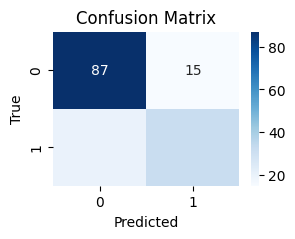

Optimal weights: [ 4.26325641e-15  3.42262184e-01  8.77935379e-01 -4.15998535e-02
 -4.98390034e-02  8.90916944e-02  4.56936097e-01  2.27341780e-01
  4.47035022e-02]

Mean values of metrics:
   Accuracy rate  F1 score  Precision    Recall
0       0.773466   0.63687    0.57163  0.723763


In [53]:
KFold_with_diabetes_data(
    method='sklearn SVM',
    classifier=sklearn.svm.SVC(kernel='linear', C=1, max_iter=10000),
    result_processor=WeightsProcessor()
)

The performance of SVM is very similar to that of logistic regression.

### Grid Search for SVM

Let's try to tune the value `C` of SVM using grid search. I will try the set of values $\{0.01, 0.1, 0.5, 1.0, 2.0\}$.

In [54]:
run_grid_search(
    grid_classifiers=[sklearn.svm.SVC(kernel='linear', C=C, max_iter=10000) for C in [0.01, 0.1, 0.5, 1.0, 2.0]],
    grid=[0.01, 0.1, 1, 10],
    result_processor=WeightsProcessor(),
)

(SVC(C=0.5, kernel='linear', max_iter=10000), 1, 0.636869547514935)

We can see that the best value for `C` is $0.5$. However, the improvement is not significant compared to the value `C` of $1.0$ that we used previously. This suggests that tuning this hyperparameter probably will not improve the performance much.

### Bootstrap Sampling for SVM

A similarity between logistic regression and SVM is that they both calculate the coefficients. Let's apply bootstrap sampling to see what it says about the importance of the features.

samples_size = 691
Pregnancies 0.3488296146524472
Glucose 0.8786284488978043
BloodPressure -0.0671970753560164
SkinThickness -0.05411482457822605
Insulin 0.06856972990347604
BMI 0.47631236427201884
DiabetesPedigreeFunction 0.22302919123747755
Age 0.04258998737379656


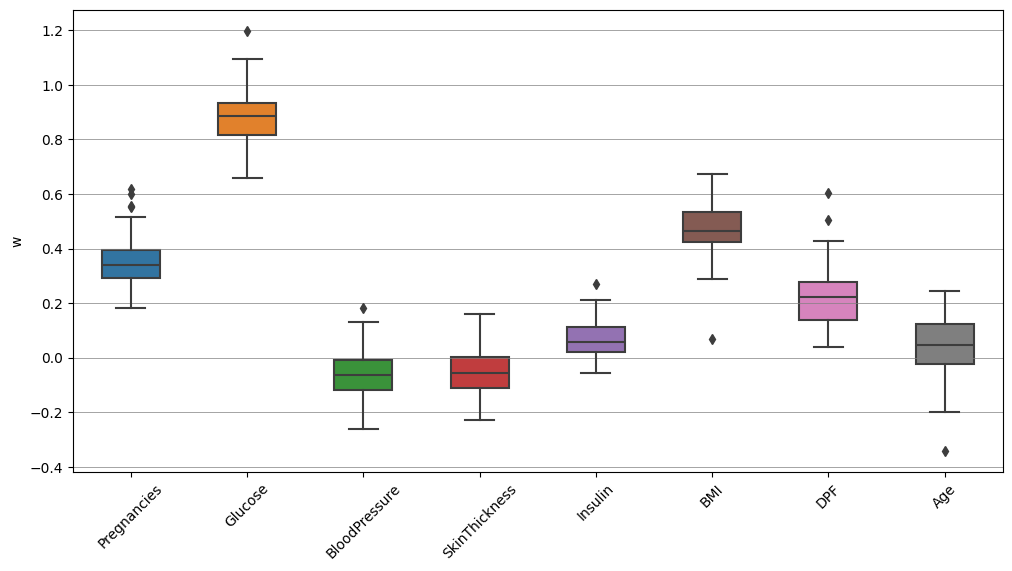

In [55]:
bootstrap_and_plot_box_plots(sklearn.svm.SVC(kernel='linear', C=1, max_iter=10000))

Once again, we can see that the most important feature is still $\mathtt{Glucose}$, followed by $\mathtt{BMI}$. The least important feature is still $\mathtt{BloodPressure}$. Besides small differences, the distributions and rankings are very similar to those of logistic regression.

## K Nearest Neighbours

Finally I will try to use the K Nearest Neighbours algorithm to solve the diabetes binary classification problem and compare the performance with the previous two approaches.

The K Nearest Neighbours algorithm is a non-parametric method used for classification and regression. It is a lazy learning algorithm that stores all instances corresponding to training data in n-dimensional space. To make a prediction for a new data point, the algorithm finds the closest data points in the training data set — its "nearest neighbours".

### Pairwise Distances

In [56]:
# the pairwise distance is computed considering all the rows of from-data against all the rows of y
def pairwise_distances(from_data, to_data):
    return np.sqrt(np.sum((from_data[:, np.newaxis, :] - to_data[np.newaxis, :, :])**2,axis=2))
# note how np.newaxis is used to extend the order of the array



def test_pairwise_distances():
  test_from_data = np.array(
      [[0, 1, 2],
      [3, 4, 5]]
  )
  test_to_data = np.array(
      [[0, 1, 2],
      [3, 4, 5],
      [6, 7, 8],
      [9, 10, 11]]
  )
  np.testing.assert_array_almost_equal(
      pairwise_distances(test_from_data, test_to_data),
      np.array([[ 0., 5.19615242, 10.39230485, 15.58845727],
                [ 5.19615242,  0., 5.19615242, 10.39230485]])
  )
  print(f'{pairwise_distances}: Test passed')

test_pairwise_distances()

<function pairwise_distances at 0x13a96c4c0>: Test passed


Similar to the binary logistic regression, I will define a class for the K Nearest Neighbours classifier and another result processor which in this case will do nothing since there are no weights to process.

In [57]:
# we can put all together!

class KNearestNeighbourClassifier:
    def __init__(self, params):
        self.params = params

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        distances = pairwise_distances(X_test, self.X_train)

        no_of_classes = 1 + np.max(self.y_train)
        sorted_indices = np.argsort(distances, axis=1)

        test_size = len(X_test)
        train_size = len(self.X_train)
        new_array_to_sort = np.broadcast_to(
            self.y_train,
            (test_size, train_size)
        )
        sorted_labels = np.take_along_axis(
            new_array_to_sort, sorted_indices, 1
        )

        predicted_labels=np.zeros(test_size,int)
        k_neighbours=self.params['k_neighbours']
        for id_input in range(test_size):

            probability_labels=np.zeros(no_of_classes,float)

            for id_neighbor in range(0, k_neighbours):
                probability_labels[sorted_labels[id_input][id_neighbor]] += 1.0 / k_neighbours

            predicted_labels[id_input]=np.argmax(probability_labels)

        return predicted_labels


class KNearestNeighbourClassifierResultProcessor:
    def compute_and_save_results(self, classifier, k_splits): pass

    def print_results(self): pass

    def reset(self): pass

I will try to run K Nearest Neighbours using K-fold cross validation with $K=5$. I will use $k=3$ for the number of neighbours.


 ------------------ 
 Using sklearn KNN 
 ------------------ 

Confusion matrix for split 0:
[[74 28]
 [23 29]]


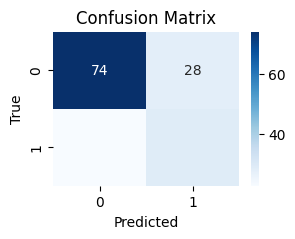


Mean values of metrics:
   Accuracy rate  F1 score  Precision   Recall
0       0.705747  0.570164    0.55851  0.58545


In [58]:
KFold_with_diabetes_data(
    method='sklearn KNN',
    classifier=KNearestNeighbourClassifier({'k_neighbours': 3}),
    result_processor=KNearestNeighbourClassifierResultProcessor()
)

The performance of K Nearest Neighbours with $k=3$ is slightly worse than that of logistic regression and SVM. 

Let's try to tune the number of neighbours using grid search to see if we can do better.

### Grid Search for K in KNN

I will try the values from 1 to 20

In [59]:
run_grid_search(
    grid_classifiers=[KNearestNeighbourClassifier({'k_neighbours': k}) for k in range(1, 21)],
    grid=range(1, 20),
    result_processor=KNearestNeighbourClassifierResultProcessor(),
)

(<__main__.KNearestNeighbourClassifier at 0x13a732a90>, 11, 0.611982831982832)

It turns out that the best value for $k$ is $11$ and the F1 score is $0.61$ which is closer to the performance of logistic regression and SVM.

Let's run K-fold cross validation again using the K Nearest Neighbours classifier with $k=11$.


 ------------------ 
 Using sklearn KNN 
 ------------------ 

Confusion matrix for split 0:
[[80 22]
 [21 31]]


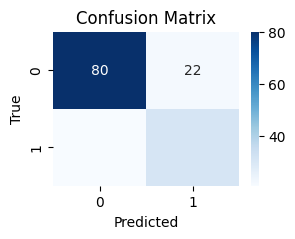


Mean values of metrics:
   Accuracy rate  F1 score  Precision    Recall
0       0.744835  0.611983     0.5763  0.655297


In [60]:
KFold_with_diabetes_data(
    method='sklearn KNN',
    classifier=KNearestNeighbourClassifier({'k_neighbours': 11}),
    result_processor=KNearestNeighbourClassifierResultProcessor()
)

## Conclusion

We have looked at three different learning algorithms to solve the diabetes binary classification problem. Overall all methods discussed here outperformed the baseline.  With the right hyperparameters, the performances of the three algorithms are very similar. For logistic regression, the best F1 score is around $0.63$ which is achieved with a step size of $0.01$. For K Nearest Neighbours, the best F1 score of $0.61$ which is achieved with $k=11$ neighbours. The performance of SVM is very similar to that of logistic regression, and tuning the hyperparameter `C` does not seem to improve the performance much.